## Init

In [ ]:
# Chargement des librairies nécessaires
library(ggplot2)
library(tidyverse)
library(gridExtra)
library(GGally)
library(plotly)
library(corrplot)
library(reshape2)
library(FactoMineR) 
library(factoextra)
library(glmnet) 
library(ggfortify)
library(pROC)
library(ROCR)
library(repr)
library(caret)

# fix random seed for reproducibility
set.seed(1234)

## GRAPH SETTINGS ##
# Save original parameters (optional)
original_par <- par(no.readonly = TRUE)

# Set global scaling factors (1.5x default size)
par(
  cex.lab = 1.5,   # Axis labels
  cex.axis = 1.5,  # Axis text (tick labels)
  cex.main = 1.5,  # Main title
  cex.sub = 1.5    # Subtitle
)

# Define a custom theme with larger fonts
custom_theme <- theme(
  text = element_text(size = 16),            # Global text size
  axis.title = element_text(size = 18),      # Axis labels
  axis.text = element_text(size = 14),       # Axis tick labels
  plot.title = element_text(size = 20),      # Main title
  plot.subtitle = element_text(size = 16)    # Subtitle
)

# Apply the theme to all future plots
theme_set(custom_theme)


## DATA LOADING & PROCESSING ##
# Load data
path <- "../../" # modifier le nombre de ../ si nécessaire
gym <- read.table(paste(path, "gym_members_exercise_tracking.csv", sep = ""),
                    sep = ",", header = TRUE)

gym[,'Gender'] <- as.factor(gym[,'Gender'])
gym[,'Workout_Type'] <- as.factor(gym[,'Workout_Type'])
gym[,'Experience_Level'] <- as.factor(gym[,'Experience_Level'])
gym[,'Workout_Frequency..days.week.'] <- as.factor(gym[,'Workout_Frequency..days.week.'])

gym[, "Weight..kg."] <- log(gym[,"Weight..kg."])

max_fat <- max(gym[,"Fat_Percentage"])
gym[, "Fat_Percentage"] <- sqrt((max_fat + 1) - gym[,"Fat_Percentage"])

# renome les variables Weight..kg. et BMI en LWeight et LBMI
names(gym)[names(gym) == "Weight..kg."] <- "LWeight"
names(gym)[names(gym) == "Fat_Percentage"] <- "SFat_Percentage"

gym <- gym %>% select(-c(BMI))

# divide data into training and testing sets for experience level
trainIndex <- createDataPartition(gym$Experience_Level, p = .8, 
                                  list = FALSE, 
                                  times = 1)
gym_train <- gym[ trainIndex,]
gym_test  <- gym[-trainIndex,]

# Normalize the data
gym_train_scaled = gym_train
scaler <- scale(gym_train[,-c(2,10,13,14)])

# Extract the center and scale attributes
center <- attr(scaler, "scaled:center")
scale <- attr(scaler, "scaled:scale")

gym_train_scaled[,-c(2,10,13,14)] <- scale(gym_train[,-c(2,10,13,14)], center = center, scale = scale)

gym_test_scaled = gym_test
gym_test_scaled[,-c(2,10,13,14)] <- scale(gym_test[,-c(2,10,13,14)], center = center, scale = scale)


cat("Data loaded and preprocessed")


## FUNCTION DEFINITIONS ##

# Function to plot residuals
# x: predicted values
# y: residuals
gplot.res <- function(x, y, titre = "titre"){
    ggplot(data.frame(x=x, y=y),aes(x,y))+
    geom_point(col = "blue")+#xlim(0, 250)+ylim(-155, 155)+
    ylab("Résidus")+ xlab("Valeurs prédites")+
    ggtitle(titre)+
    geom_hline(yintercept = 0,col="green")
}

# Function to plot ROC curve
# model: model to evaluate
# data: data to evaluate
# title: title of the plot
plot_roc <- function(model, data, title = "ROC curve"){
    pred <- predict(model, data, type = "response")
    roc <- roc(data$Experience_Level, pred)
    auc <- round(auc(roc), 2)
    plot(roc, main = title)
    text(0.8, 0.2, paste("AUC = ", auc), cex = 1.5)
}

# Function that compute R2

# compute_R2 <- function(model, newdata = NA){
#   if newdata == NA{
#     residuals <- predict(model)
#       rss <- sum()
#       tss <- 
# }
#   res.tree.cal.cp_high.test <- predict(tree.reg.cal.cp_high, newdata = gym_test)
#   mse_test_cal_cp_high <- mean((res.tree.cal.cp_high.test - gym_test[,"Calories_Burned"])^2)
#   rss_cal_cp_high <- sum((res.tree.cal.cp_high.test - gym_test[,"Calories_Burned"])^2)
#   tss_cal_cp_high <- sum((gym_test[,"Calories_Burned"] - mean(gym_test[,"Calories_Burned"]))^2)
#   r2_test_cal_cp_high <- 1 - rss_cal_cp_high / tss_cal_cp_high
# }



In [2]:
summary(gym_train_scaled)
summary(gym_test_scaled)

      Age              Gender       LWeight           Height..m.      
 Min.   :-1.70033   Female:384   Min.   :-2.06411   Min.   :-1.74278  
 1st Qu.:-0.88351   Male  :395   1st Qu.:-0.70877   1st Qu.:-0.79206  
 Median : 0.09668                Median :-0.05133   Median :-0.07902  
 Mean   : 0.00000                Mean   : 0.00000   Mean   : 0.00000  
 3rd Qu.: 0.91350                3rd Qu.: 0.67508   3rd Qu.: 0.55479  
 Max.   : 1.64864                Max.   : 2.18326   Max.   : 2.21854  
    Max_BPM            Avg_BPM          Resting_BPM      
 Min.   :-1.70393   Min.   :-1.66558   Min.   :-1.66962  
 1st Qu.:-0.84195   1st Qu.:-0.90414   1st Qu.:-0.84618  
 Median : 0.02003   Median :-0.07349   Median :-0.02273  
 Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.00000  
 3rd Qu.: 0.88201   3rd Qu.: 0.89561   3rd Qu.: 0.80072  
 Max.   : 1.65779   Max.   : 1.72627   Max.   : 1.62417  
 Session_Duration..hours. Calories_Burned     Workout_Type SFat_Percentage   
 Min.   :-2.20445  

      Age              Gender       LWeight           Height..m.      
 Min.   :-1.70033   Female: 78   Min.   :-2.06411   Min.   :-1.74278  
 1st Qu.:-0.88351   Male  :116   1st Qu.:-0.74142   1st Qu.:-0.71283  
 Median :-0.06669                Median :-0.01540   Median :-0.07902  
 Mean   :-0.05448                Mean   : 0.03039   Mean   : 0.10352  
 3rd Qu.: 0.66845                3rd Qu.: 0.77183   3rd Qu.: 0.95092  
 Max.   : 1.64864                Max.   : 2.14138   Max.   : 2.21854  
    Max_BPM            Avg_BPM         Resting_BPM      
 Min.   :-1.70393   Min.   :-1.6656   Min.   :-1.66962  
 1st Qu.:-0.66956   1st Qu.:-0.9041   1st Qu.:-0.84618  
 Median : 0.10623   Median :-0.1427   Median : 0.11451  
 Mean   : 0.05024   Mean   :-0.1024   Mean   : 0.03953  
 3rd Qu.: 0.88201   3rd Qu.: 0.7399   3rd Qu.: 0.93796  
 Max.   : 1.65779   Max.   : 1.6571   Max.   : 1.62417  
 Session_Duration..hours. Calories_Burned      Workout_Type SFat_Percentage   
 Min.   :-2.17545        

## GLM

### Linear Regression

#### Sans selection


Call:
lm(formula = Calories_Burned ~ ., data = gym_train_scaled)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.47154 -0.09373 -0.00760  0.07968  0.63471 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    -0.1620832  0.0212259  -7.636 6.73e-14 ***
Age                            -0.1507445  0.0053571 -28.139  < 2e-16 ***
GenderMale                      0.3303012  0.0216668  15.245  < 2e-16 ***
LWeight                         0.0086219  0.0066054   1.305    0.192    
Height..m.                      0.0020423  0.0065248   0.313    0.754    
Max_BPM                         0.0015636  0.0053842   0.290    0.772    
Avg_BPM                         0.3287440  0.0053642  61.285  < 2e-16 ***
Resting_BPM                     0.0087330  0.0053581   1.630    0.104    
Session_Duration..hours.        0.8930857  0.0087344 102.249  < 2e-16 ***
Workout_TypeHIIT                0.0049799  0.0152041   0.328    0.743    
W

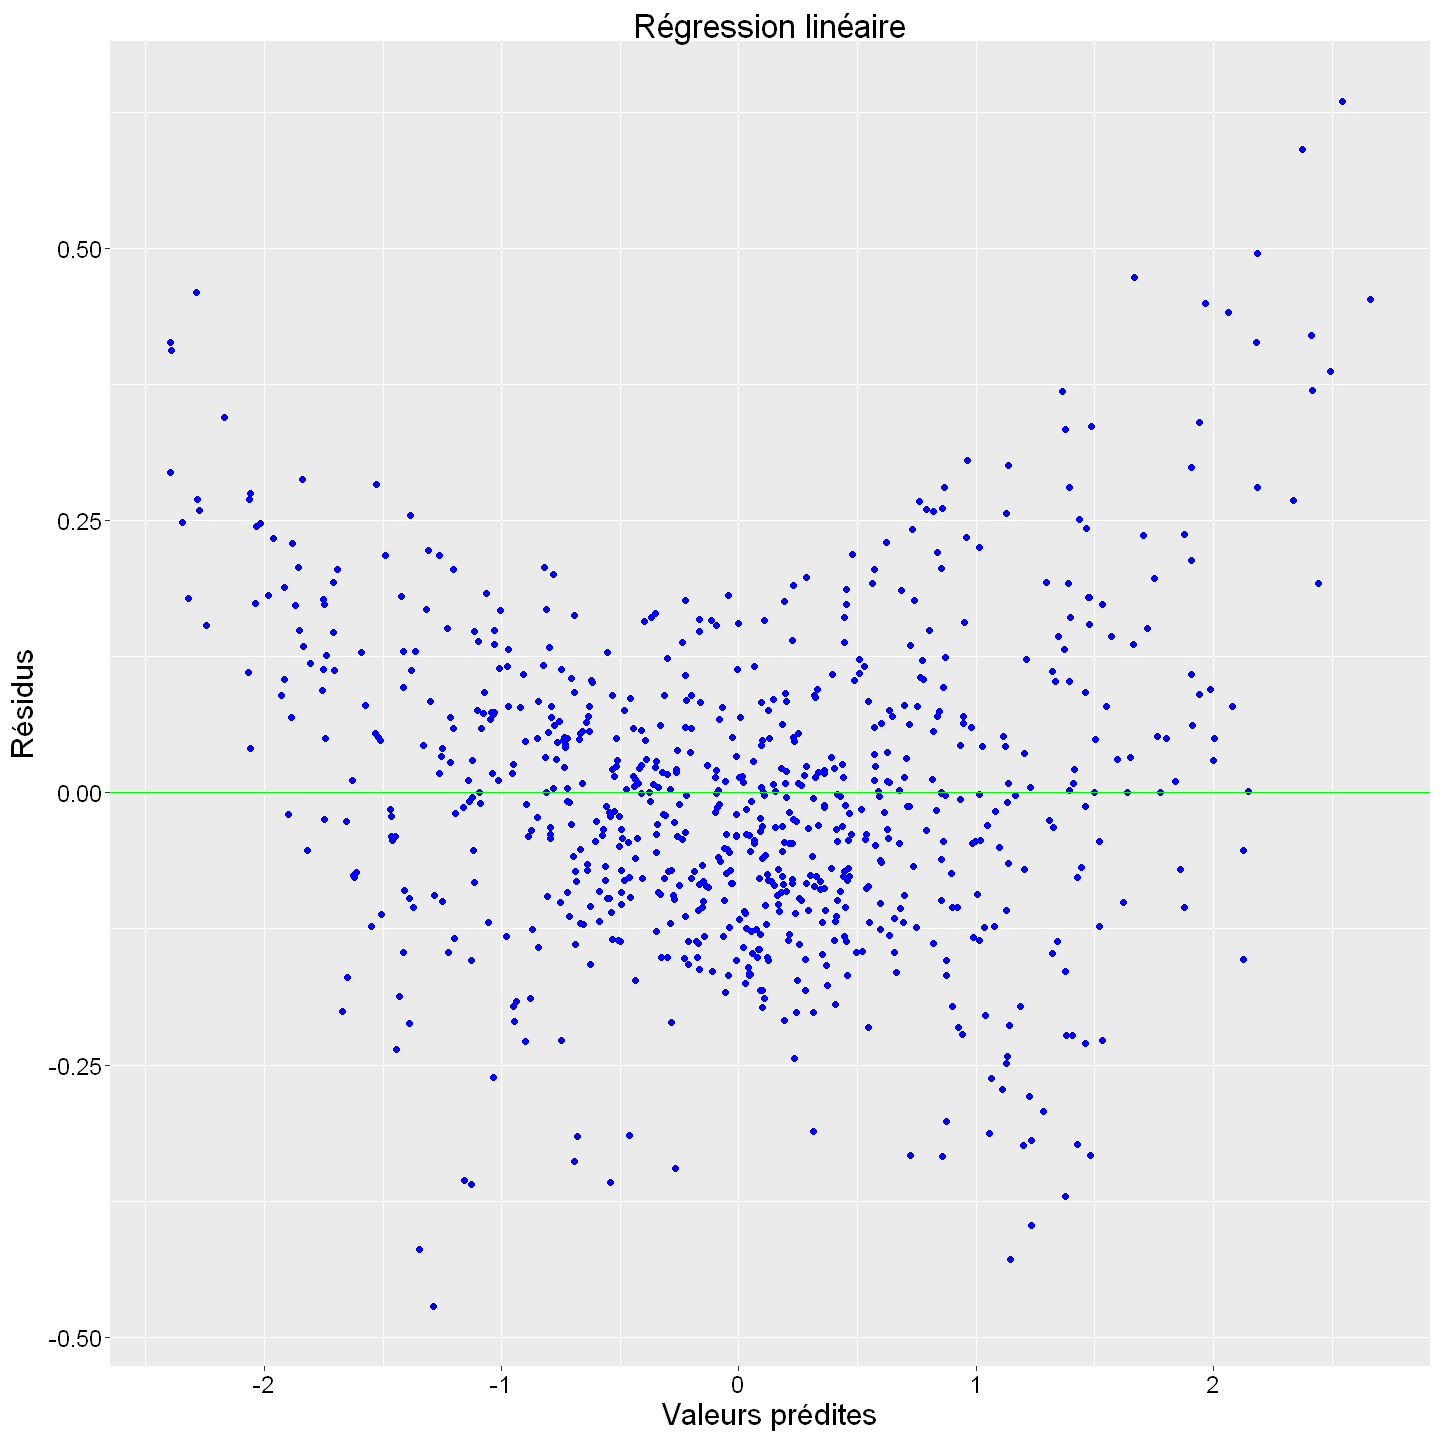

In [45]:
reg.lm <- lm(Calories_Burned ~ ., data = gym_train_scaled)

# Summary of the regression
summary(reg.lm)

# Extract the residuals
sel.lm <- reg.lm$residuals
fit.lm <- reg.lm$fitted.values

# Plot the residuals
gplot.res(fit.lm, sel.lm, "Régression linéaire")

In [46]:
# MSE of the model on the training and test set
mse_train <- mean(sel.lm^2)
mse_test <- mean((predict(reg.lm, gym_test_scaled) - gym_test_scaled$Calories_Burned)^2)

cat("MSE on training set: ", mse_train, "\n")
cat("MSE on test set: ", mse_test, "\n")

MSE on training set:  0.02144403 


MSE on test set:  0.01608908 


**Interprétation** : Giga trompette, on va rajouter des termes quadratiques

#### LASSO

,Age,GenderFemale,GenderMale,LWeight,Height..m.,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration..hours.,Workout_TypeHIIT,Workout_TypeStrength,Workout_TypeYoga,SFat_Percentage,Water_Intake..liters.,Workout_Frequency..days.week.3,Workout_Frequency..days.week.4,Workout_Frequency..days.week.5,Experience_Level2,Experience_Level3
2,0.58677041,1,0,0.19779559,-1.5050986225,-0.06617008,0.4802851,0.5262388,0.11582778,1,0,0,-1.7625553,-0.8567881,0,1,0,1,0
3,-0.55678178,1,0,-0.14540416,-0.4751551297,-1.10054779,-1.5271377,-1.1206579,-0.43523841,0,0,0,-1.5948489,-0.5262097,0,1,0,1,0
5,-0.06668799,0,1,-1.55230634,0.5547883631,0.70961321,0.9648354,0.8007216,-1.79840214,0,1,0,-0.5728511,0.3002366,1,0,0,0,0
6,1.40359340,1,0,-0.72427809,-0.3167022846,-1.01434964,0.8263925,1.6241700,0.95692880,1,0,0,1.3988024,0.1349473,0,0,1,0,1
7,-0.23005259,0,1,-0.03075534,0.0002034054,-0.49716079,1.7262717,1.4869286,0.66689396,0,0,0,0.6865113,-0.5262097,1,0,0,1,0
8,0.09667661,1,0,-0.06166344,-1.6635514675,0.79581135,-0.2119297,0.2517560,0.02881733,0,0,0,-0.8643778,-1.1873666,1,0,0,1,0


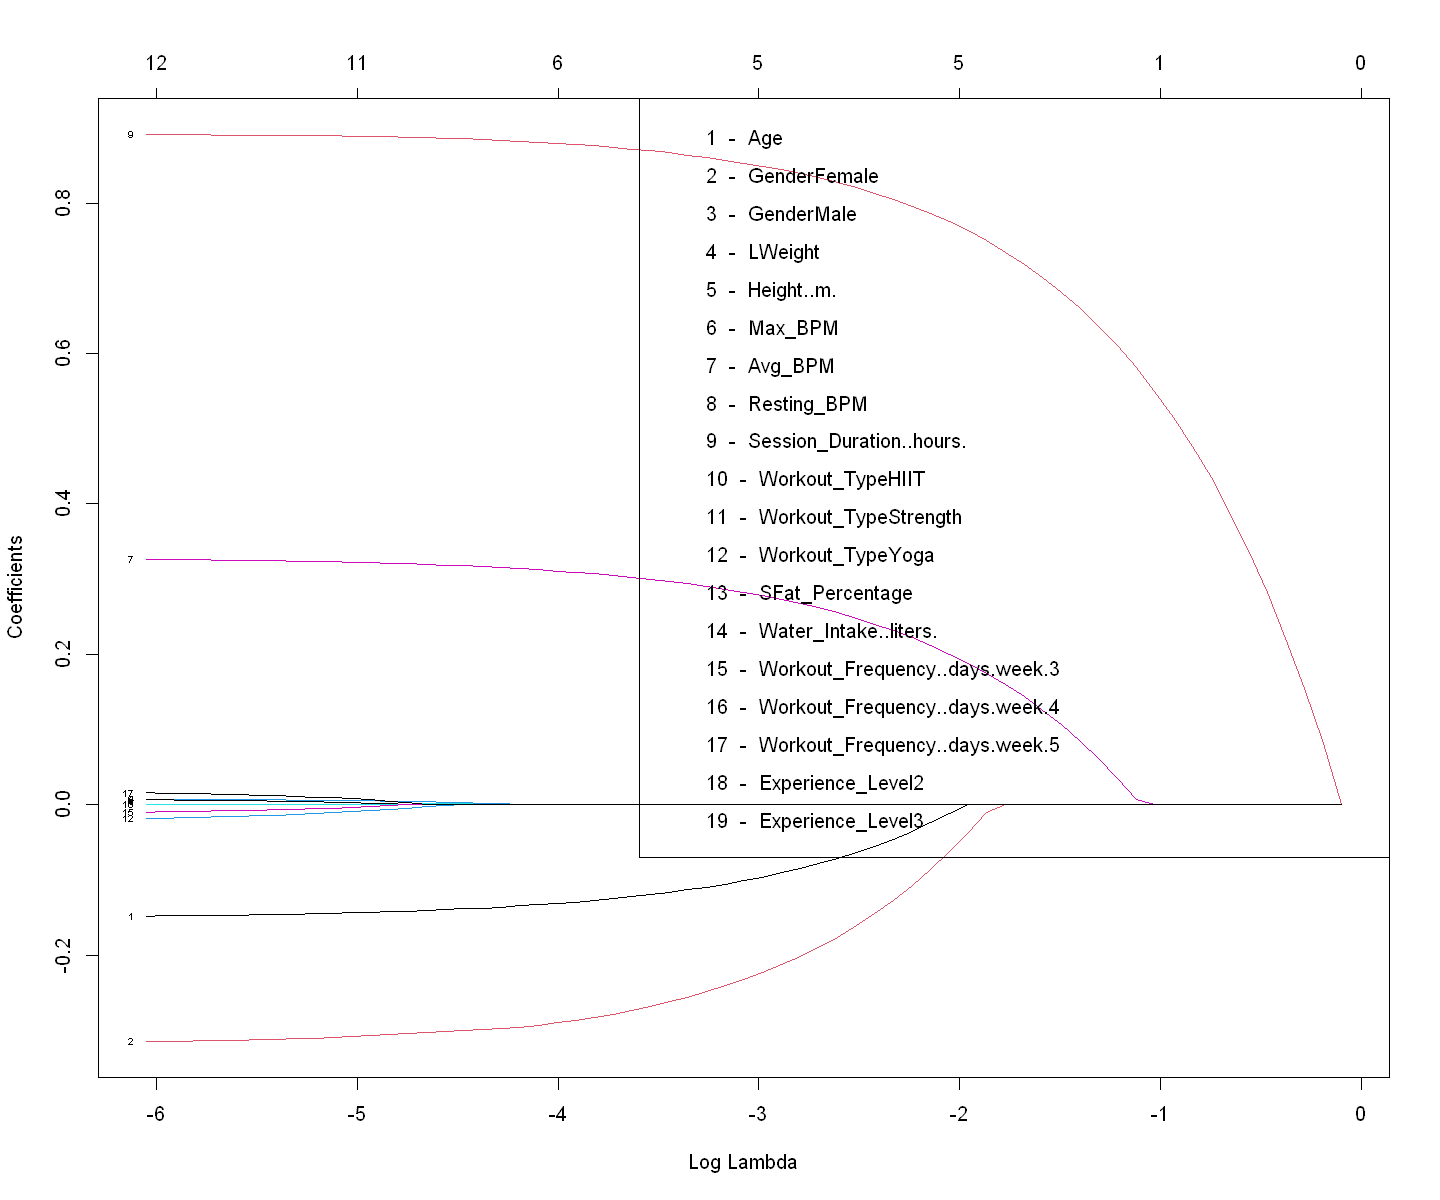

In [47]:
x.mat <- model.matrix(Calories_Burned ~ . -1, data = gym_train_scaled)
y.vec <- gym_train_scaled$Calories_Burned

head(x.mat)

# Fit the lasso model
reg.lasso <- glmnet(x.mat, y.vec, alpha = 1, nfolds = 10) # alpha = 1 for lasso

# Plot the coefficients
options(repr.plot.width=12, repr.plot.height=10)
plot(reg.lasso, xvar = "lambda", label = TRUE)
legend("topright", 
       legend = paste(1:ncol(x.mat), " - ", colnames(x.mat)))



Call:  cv.glmnet(x = x.mat, y = y.vec, nfolds = 10, alpha = 1) 

Measure: Mean-Squared Error 

      Lambda Index Measure       SE Nonzero
min 0.003417    61 0.02257 0.002322      10
1se 0.024106    40 0.02476 0.003223       5

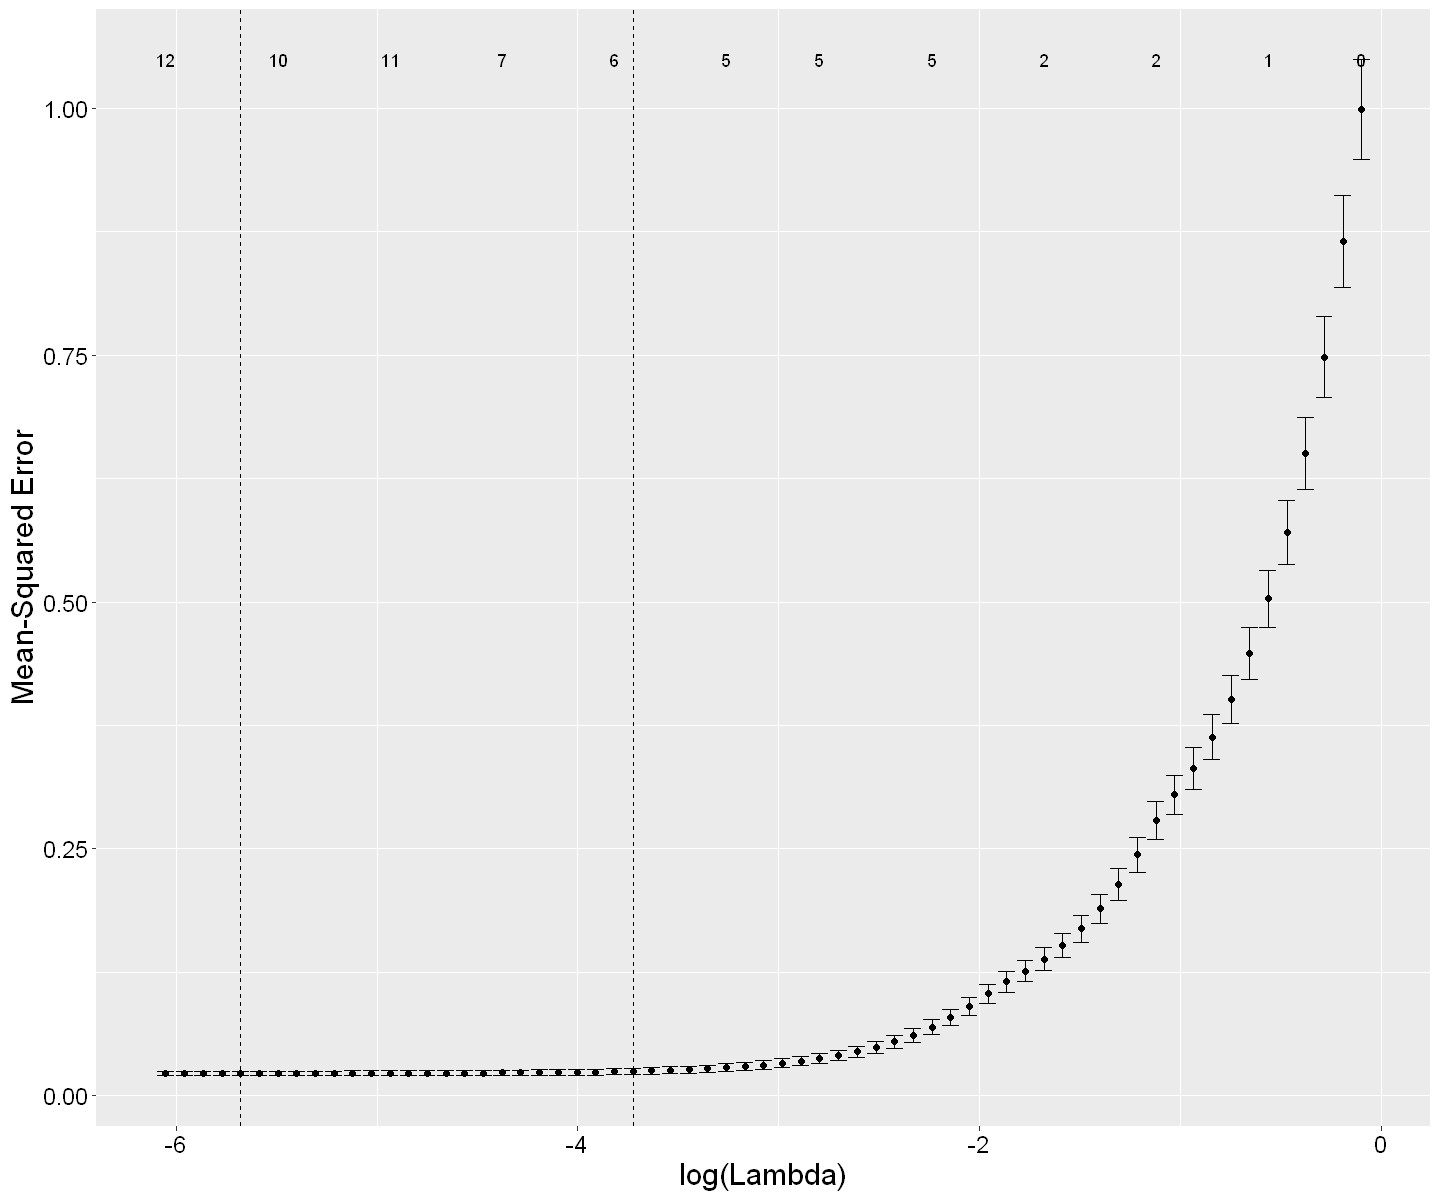

In [48]:
# Cross-validation
reg.lasso.cv <- cv.glmnet(x.mat, y.vec, alpha = 1, nfolds = 10)
reg.lasso.cv
autoplot(reg.lasso.cv)

In [49]:
cat("Best lambda: ", round(reg.lasso.cv$lambda.min,5), "\t \t")
cat("MSE for best lambda: ", round(reg.lasso.cv$cvm[which.min(reg.lasso.cv$cvm)],5), "\n")
cat("Best lambda 1se: ", round(reg.lasso.cv$lambda.1se,5), "\t")
cat("MSE for best lambda 1se: ", round(reg.lasso.cv$cvm[which.min(reg.lasso.cv$cvm)],5), "\n")


# Extract the best model
coef(reg.lasso.cv, s = "lambda.1se")

Best lambda:  0.00342 	 	MSE for best lambda:  0.02257 
Best lambda 1se:  0.02411 	MSE for best lambda 1se:  0.02257 


20 x 1 sparse Matrix of class "dgCMatrix"
                                          s1
(Intercept)                     1.372096e-01
Age                            -1.250175e-01
GenderFemale                   -2.783496e-01
GenderMale                      3.172129e-14
LWeight                         .           
Height..m.                      .           
Max_BPM                         .           
Avg_BPM                         3.048149e-01
Resting_BPM                     .           
Session_Duration..hours.        8.740339e-01
Workout_TypeHIIT                .           
Workout_TypeStrength            .           
Workout_TypeYoga                .           
SFat_Percentage                 .           
Water_Intake..liters.           .           
Workout_Frequency..days.week.3  .           
Workout_Frequency..days.week.4  .           
Workout_Frequency..days.week.5  .           
Experience_Level2               .           
Experience_Level3               .           

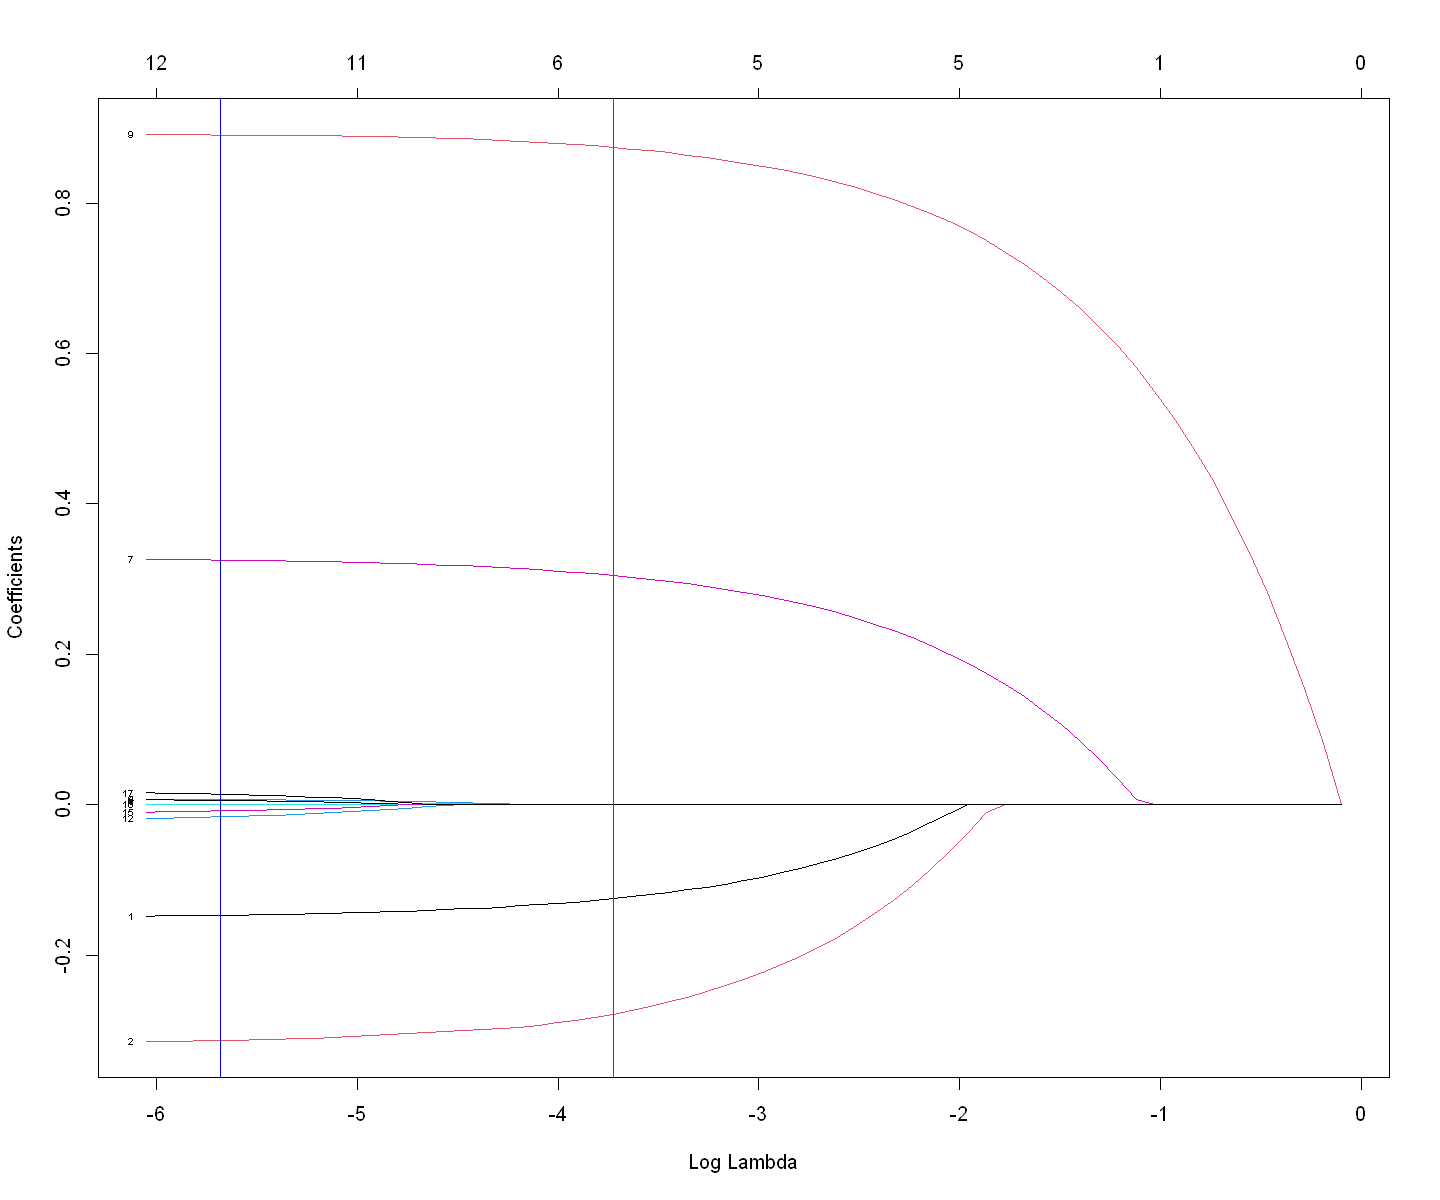

In [50]:
plot(reg.lasso, xvar = "lambda", label = TRUE)
abline(v=log(reg.lasso.cv$lambda.1se),col="red")
abline(v=log(reg.lasso.cv$lambda.min),col="blue")

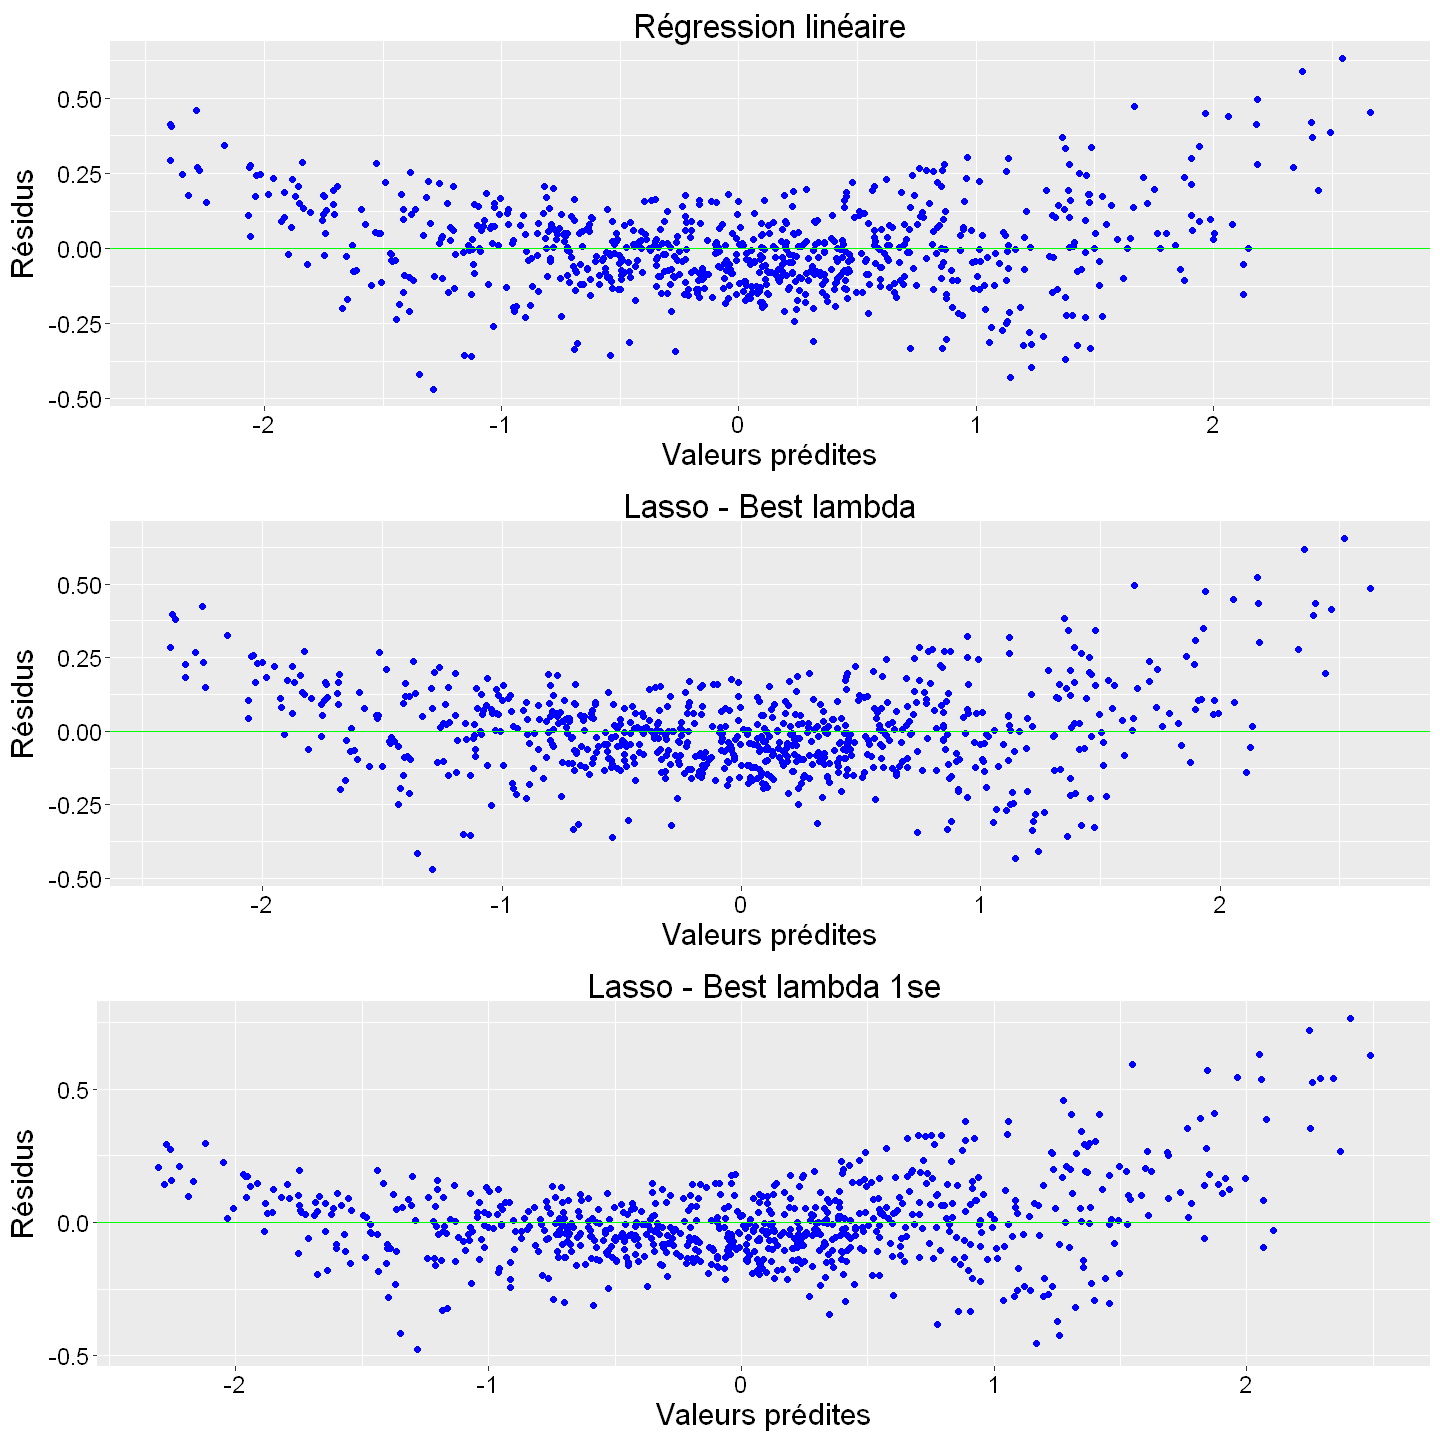

In [51]:
# Extract fitted values and residuals
fit.lasso.min <- predict(reg.lasso.cv, s = "lambda.min", newx = x.mat)
res.lasso.min <- y.vec - fit.lasso.min

fit.lasso.1se <- predict(reg.lasso.cv, s = "lambda.1se", newx = x.mat)
res.lasso.1se <- y.vec - fit.lasso.1se

# Plot the residuals
options(repr.plot.width=12, repr.plot.height=12)
p0 <- gplot.res(fit.lm, sel.lm, "Régression linéaire")
p1 <- gplot.res(fit.lasso.min, res.lasso.min, "Lasso - Best lambda")
p2 <- gplot.res(fit.lasso.1se, res.lasso.1se, "Lasso - Best lambda 1se")

grid.arrange(p0, p1, p2, ncol = 1)
rm(p0, p1, p2)

### Modèle Quadratique

In [ ]:
# Quadratic model with lasso
x.mat.quad <- model.matrix(Calories_Burned ~ .^2 -1, data = gym_train_scaled)
reg.lasso.quad.cv <- cv.glmnet(x.mat.quad, y.vec, alpha = 1, nfolds = 10)
reg.lasso.quad.cv
# coef(reg.lasso.quad.cv, s = "lambda.1se")


Call:  cv.glmnet(x = x.mat.quad, y = y.vec, nfolds = 10, alpha = 1) 

Measure: Mean-Squared Error 

      Lambda Index  Measure        SE Nonzero
min 0.002146    66 0.009141 0.0005331      61
1se 0.009508    50 0.009667 0.0006276      21

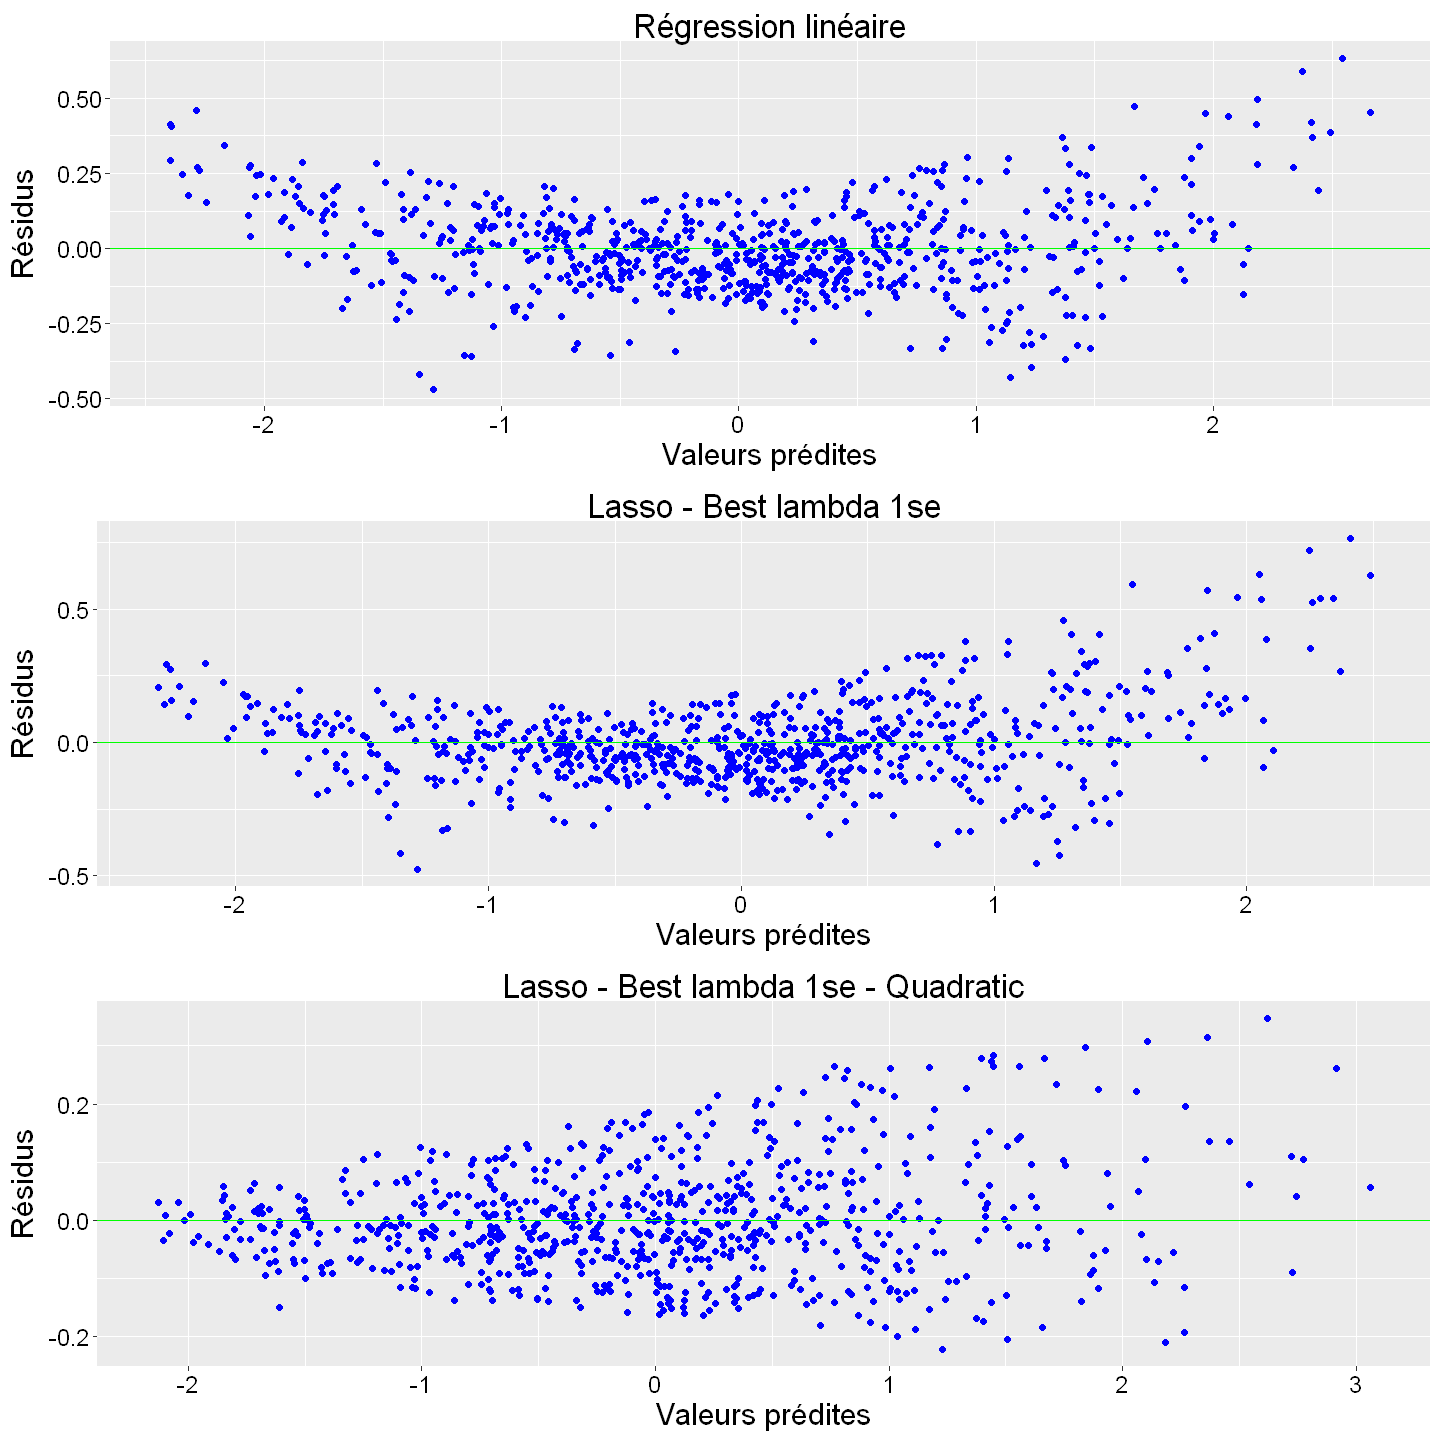

In [53]:
fit.lasso.quad.1se <- predict(reg.lasso.quad.cv, s = "lambda.1se", newx = x.mat.quad)
res.lasso.quad.1se <- y.vec - fit.lasso.quad.1se

# Plot the residuals
options(repr.plot.width=12, repr.plot.height=12)
p0 <- gplot.res(fit.lm, sel.lm, "Régression linéaire")
p1 <- gplot.res(fit.lasso.1se, res.lasso.1se, "Lasso - Best lambda 1se")
p2 <- gplot.res(fit.lasso.quad.1se, res.lasso.quad.1se, "Lasso - Best lambda 1se - Quadratic")

grid.arrange(p0, p1, p2, ncol = 1)
rm(p0, p1, p2)

## Support Vector Machines

In [13]:
library(e1071)

# SVM for regression
svm.reg0 <- svm(Calories_Burned ~ ., data = gym_train_scaled, cross = 5)
summary(svm.reg0)

Warning message:
"le package 'e1071' a été compilé avec la version R 4.4.3"
Warning message in cret$cresults * scale.factor:
"Le recyclage d’un tableau (array) de longueur 1 dans un calcul arithmétique vecteur-tableau est obsolète.
  Utilisez c() ou as.vector() à la place."



Call:
svm(formula = Calories_Burned ~ ., data = gym_train_scaled, cross = 5)


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.05263158 
    epsilon:  0.1 


Number of Support Vectors:  317



5-fold cross-validation on training data:

Total Mean Squared Error: 0.02004878 
Squared Correlation Coefficient: 0.9803508 
Mean Squared Errors:
 0.02455288 0.01902644 0.01913765 0.01659293 0.02096286 





Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
       gamma cost
 0.003162278  100

- best performance: 0.009855978 


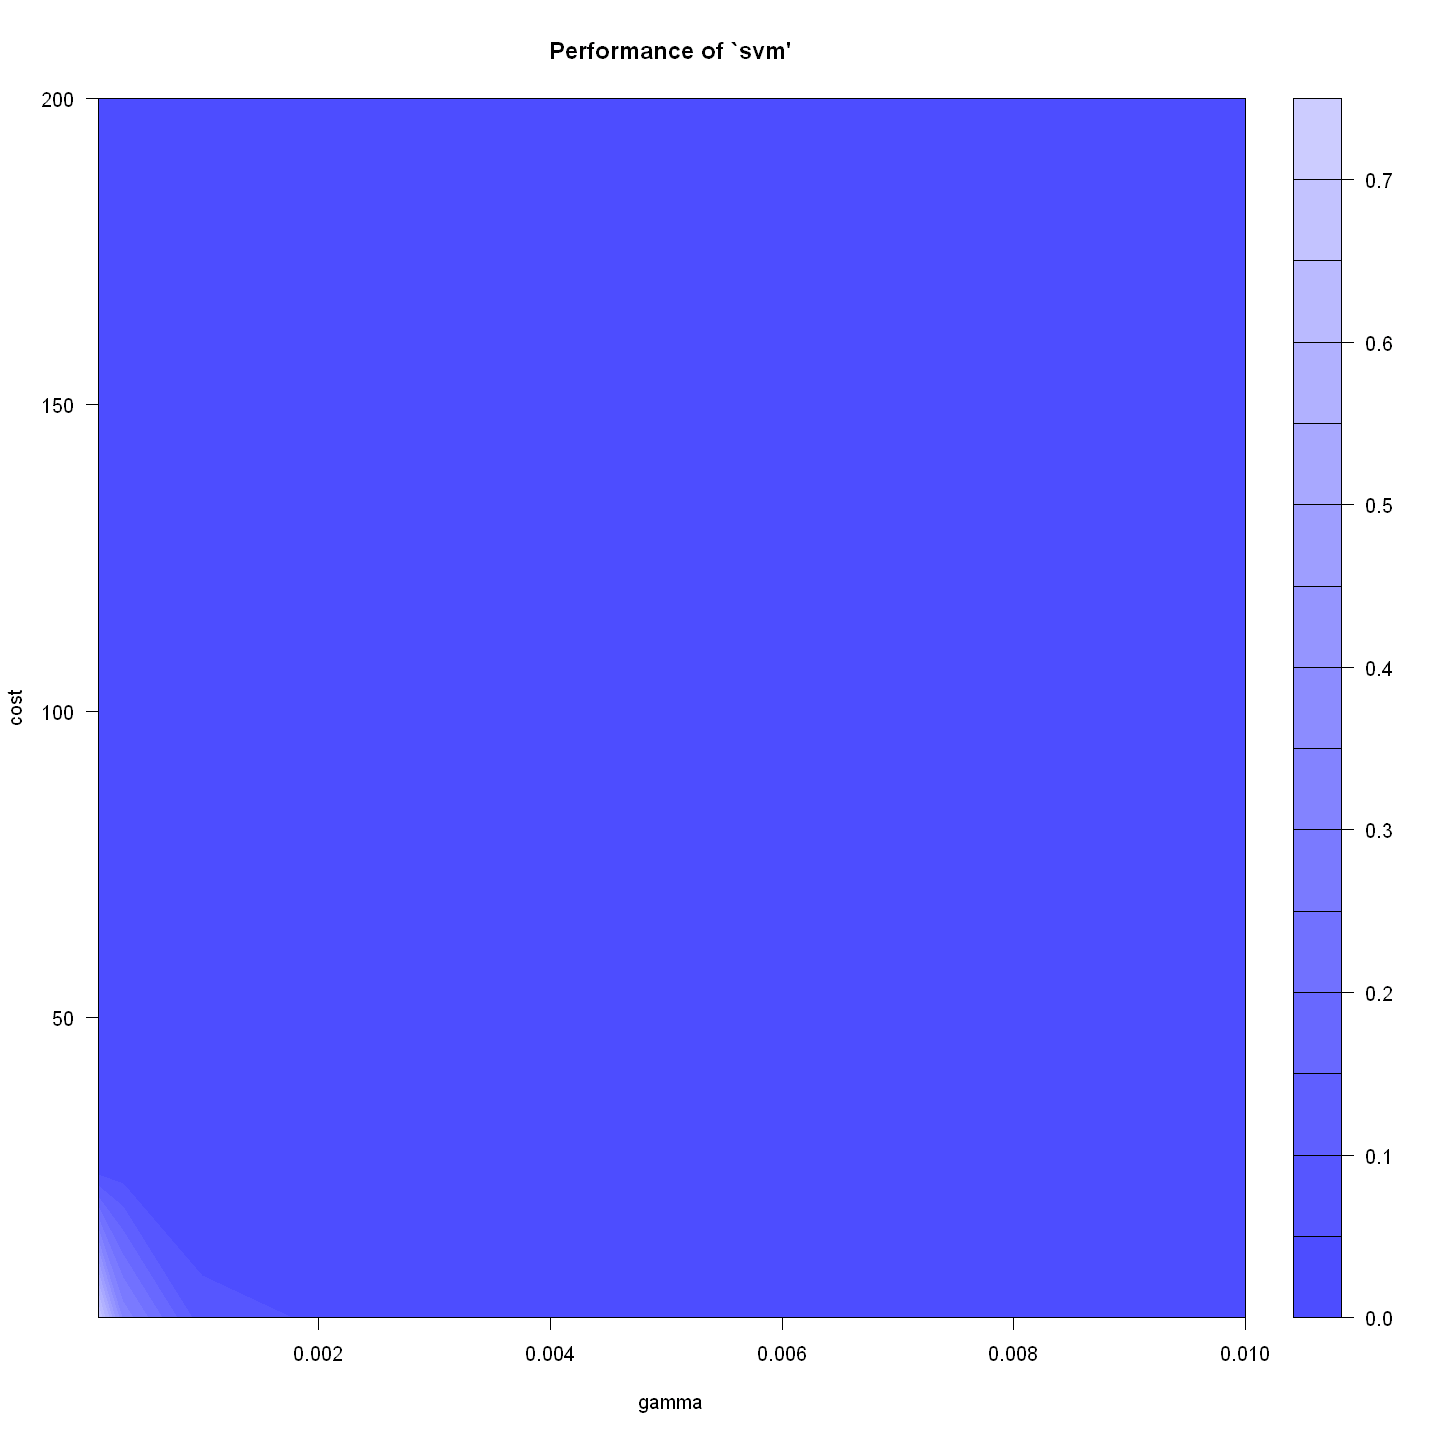

In [14]:
svm.reg.tune = tune.svm(Calories_Burned ~ ., data = gym_train_scaled, cost = c(1, 25, 50, 75, 100, 150, 200), 
    gamma = 10^seq(-4, -2, by = 0.5))
plot(svm.reg.tune)
svm.reg.tune

In [15]:
svm.reg.tune


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
       gamma cost
 0.003162278  100

- best performance: 0.009855978 


In [16]:
# Best model
svm.reg <- svm.reg.tune$best.model

# Predictions
pred.svm.reg <- predict(svm.reg, newdata=gym_test_scaled)

# Evaluate the model
cat("SVM Regression Model\n")
cat("MSE on test set: ", mean((gym_test_scaled$Calories_Burned - pred.svm.reg)^2), "\n")

SVM Regression Model
MSE on test set:  0.00822369 


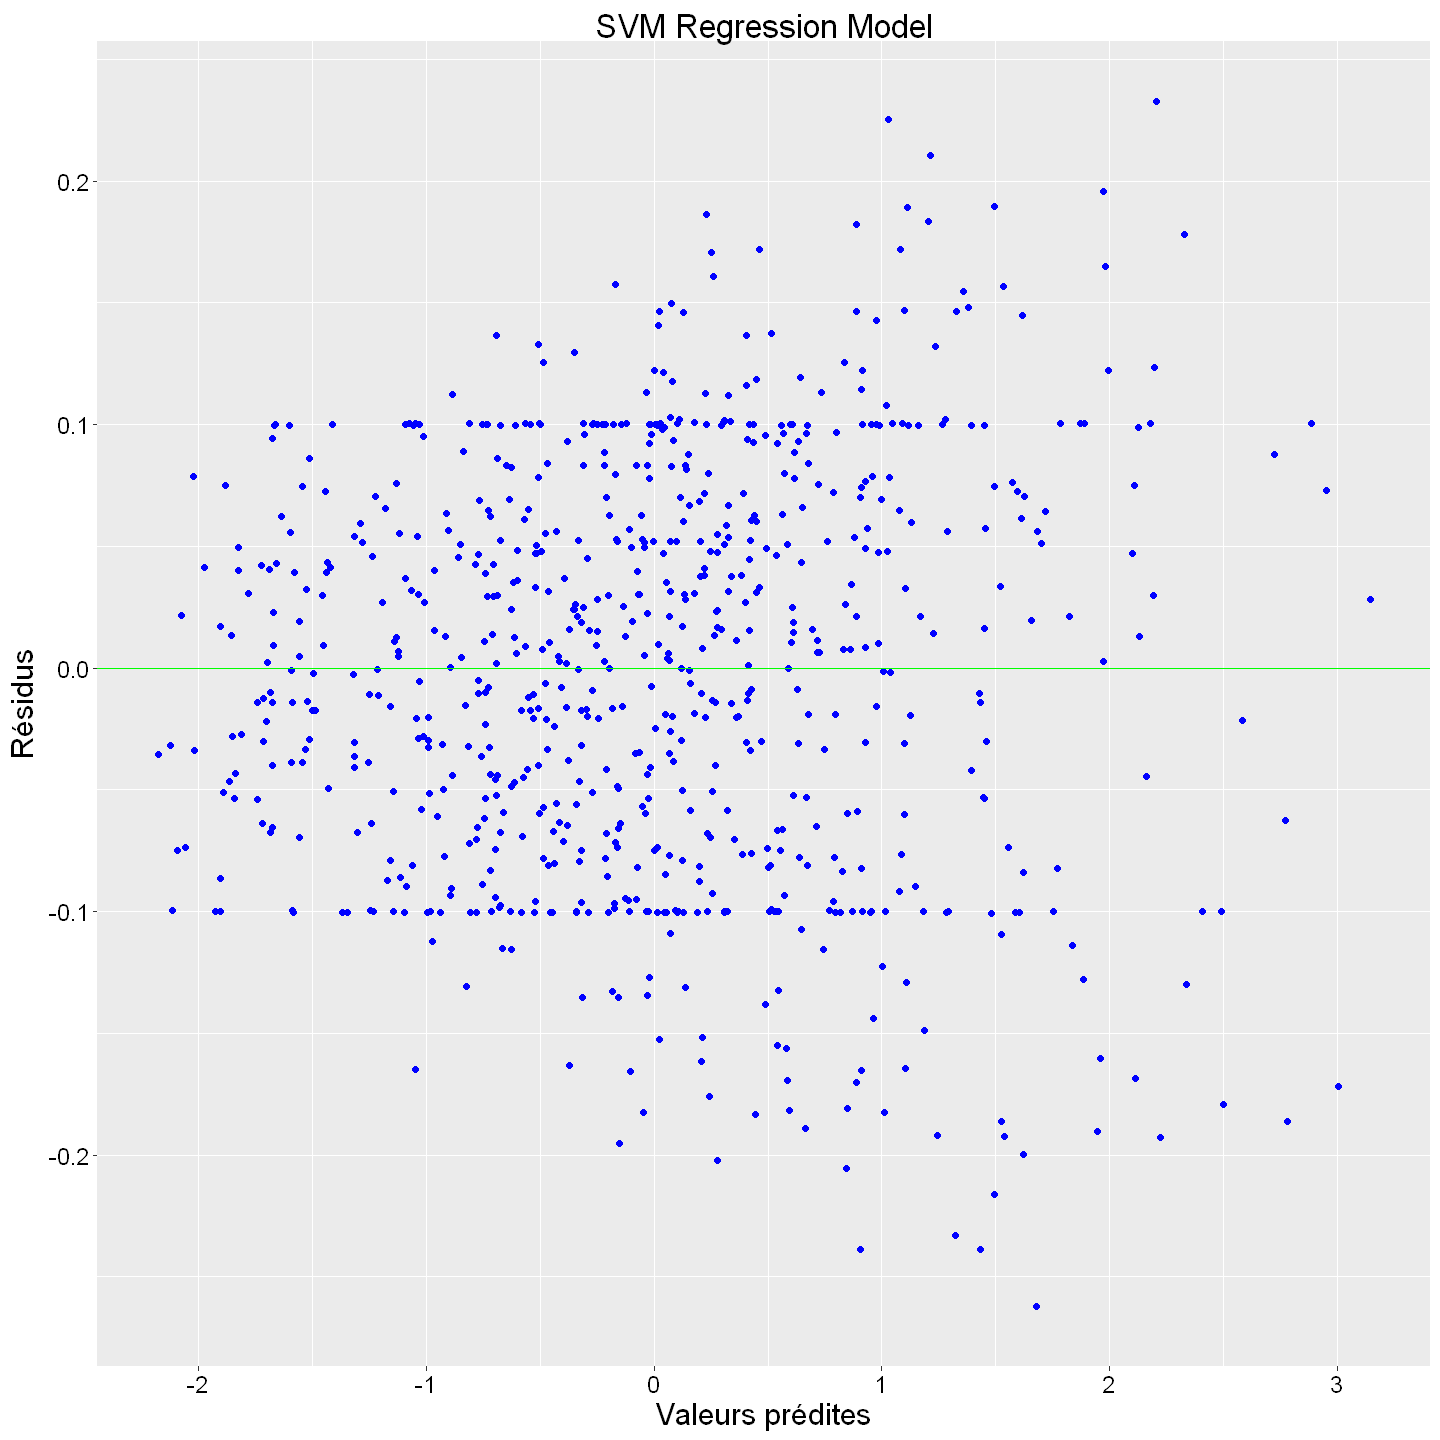

In [17]:
# graphe des résidus
fit.svm.reg = svm.reg$fitted
res.svm.reg = fit.svm.reg - gym_train_scaled$Calories_Burned
gplot.res(fit.svm.reg, res.svm.reg, "SVM Regression Model")

## CART & Agregation
### Regression Trees

- Fit a decision tree regressor.
- Prune the tree using cross-validation.
- Plot: Decision tree structure.

Warning message:
"package 'rpart.plot' was built under R version 4.4.3"


Warning message:
"labs do not fit even at cex 0.15, there may be some overplotting"


MSE on training set:  2613.292 
MSE on test set:  4521.336 
R2 on training set:  0.9655021 
R2 on test set:  0.9342961 


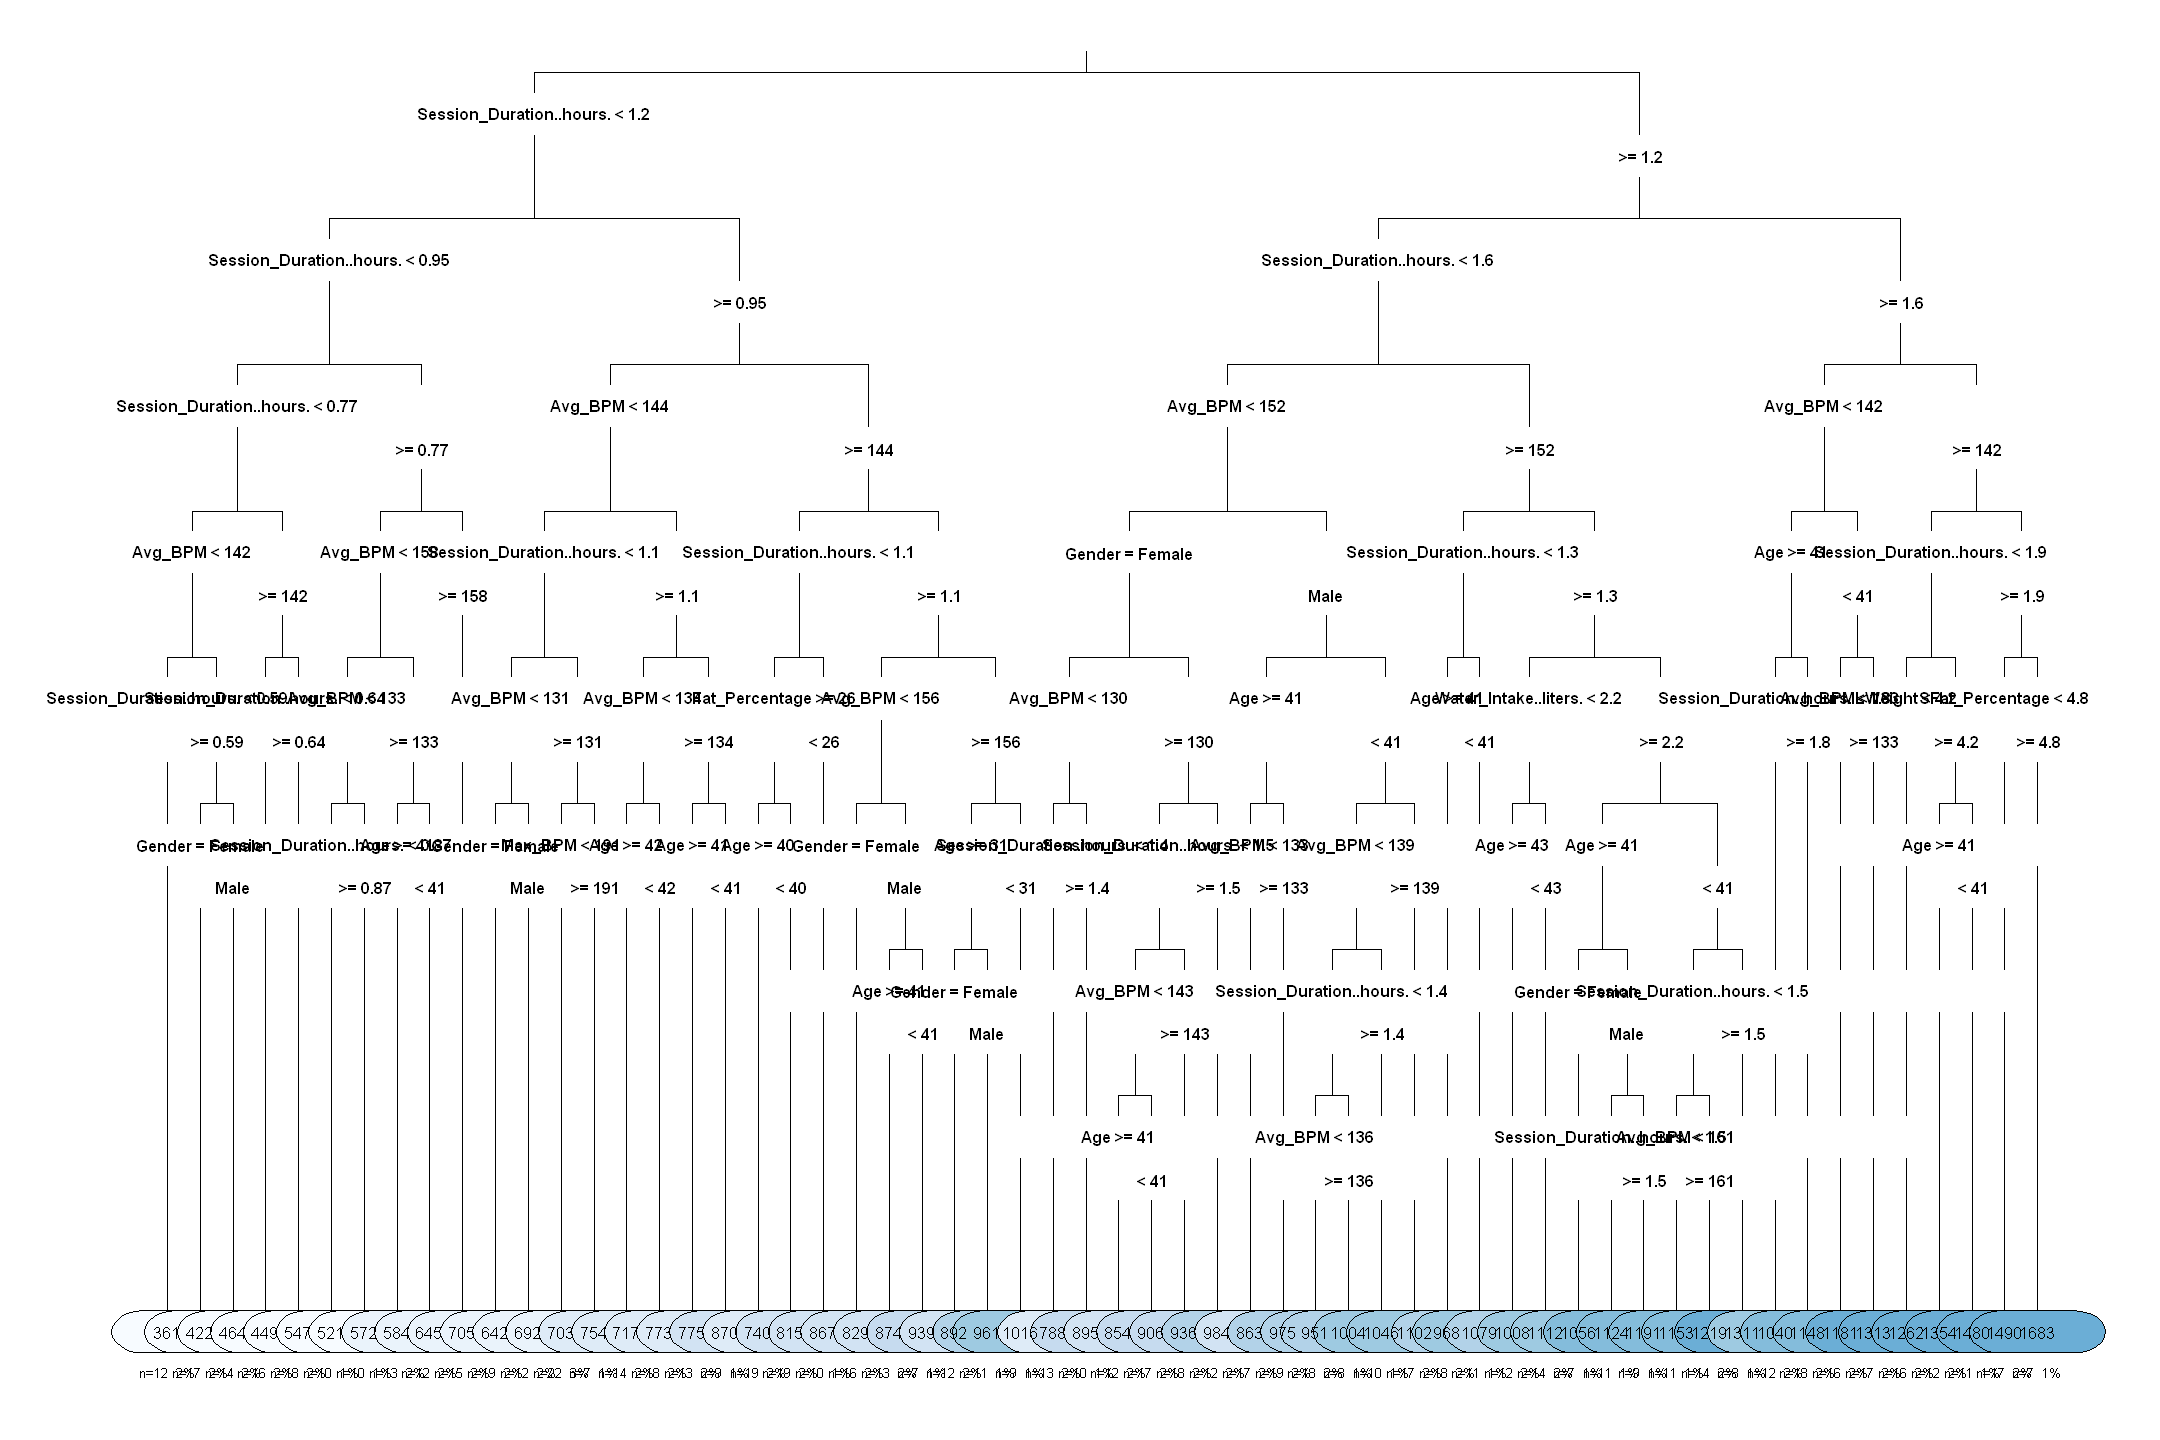

In [4]:
# Fit a regression tree model
library(rpart)
library(rpart.plot)

# Fit a regression tree model for Calories_Burned
tree.reg.cal <- rpart(Calories_Burned ~ ., data = gym_train, control=rpart.control(cp=0.0001))

options(repr.plot.width=18, repr.plot.height=12)
# Plot the tree
rpart.plot(tree.reg.cal, extra = 101, type = 3, under = TRUE, cex = 0.8, tweak = 1)

# summary(tree.reg.cal)

# compute MSE and R2 on training and test sets
mse_train <- mean((gym_train$Calories_Burned - predict(tree.reg.cal, gym_train))^2)
mse_test <- mean((gym_test$Calories_Burned - predict(tree.reg.cal, gym_test))^2)
r2_train <- 1 - mse_train / var(gym_train$Calories_Burned)
r2_test <- 1 - mse_test / var(gym_test$Calories_Burned)
cat("MSE on training set: ", mse_train, "\n")
cat("MSE on test set: ", mse_test, "\n")
cat("R2 on training set: ", r2_train, "\n")
cat("R2 on test set: ", r2_test, "\n")

**Interprétation** : Nous avons initialement construit un arbre de régression avec un paramètre de complexité extrêmement faible (`cp = 0.0001`). Comme attendu, ce modèle présente une structure profondément ramifiée (58 feuilles), caractéristique d'un sur-apprentissage. Ce modèle présente une performance relativement bonne sur le jeu d’entraînement (R² = 0.966, MSE = 2613), mais un écart significatif entre l’erreur d’entraînement et de test (MSE_test = 4521) révèle un sur-apprentissage. Toutefois, le R² sur le test reste élevé (0.934), indiquant que le modèle capture une part substantielle de la variance explicative, malgré sa complexité excessive.

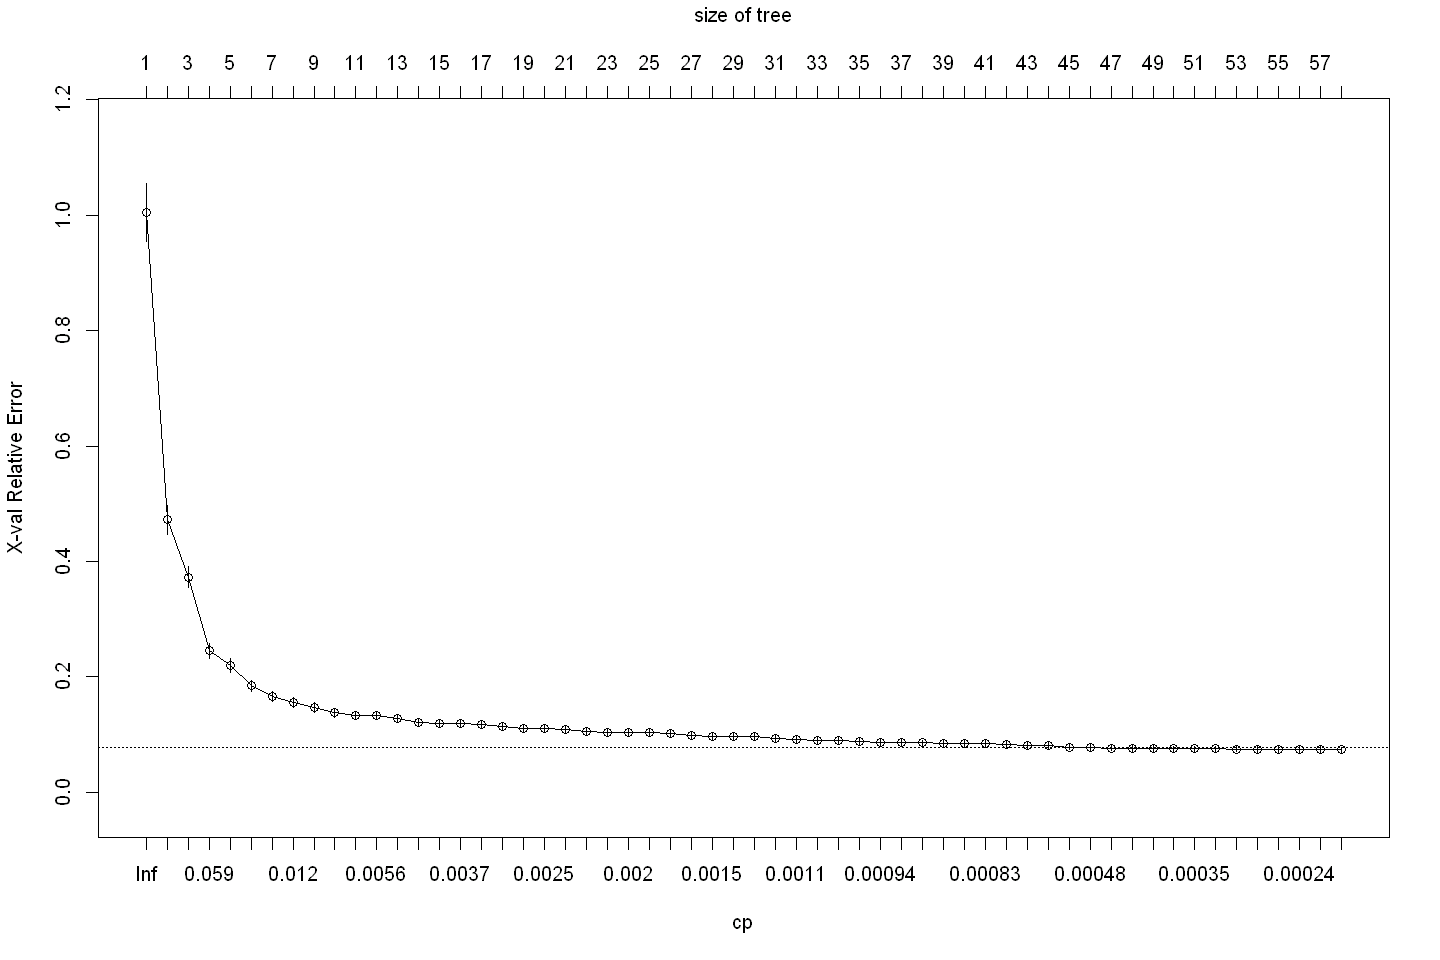

In [5]:
options(repr.plot.width=12, repr.plot.height=8)

xmat = xpred.rpart(tree.reg.cal, xval = 10)

CVerr<-apply((xmat-gym_train[,"Calories_Burned"])^2,2,sum)

plotcp(tree.reg.cal)

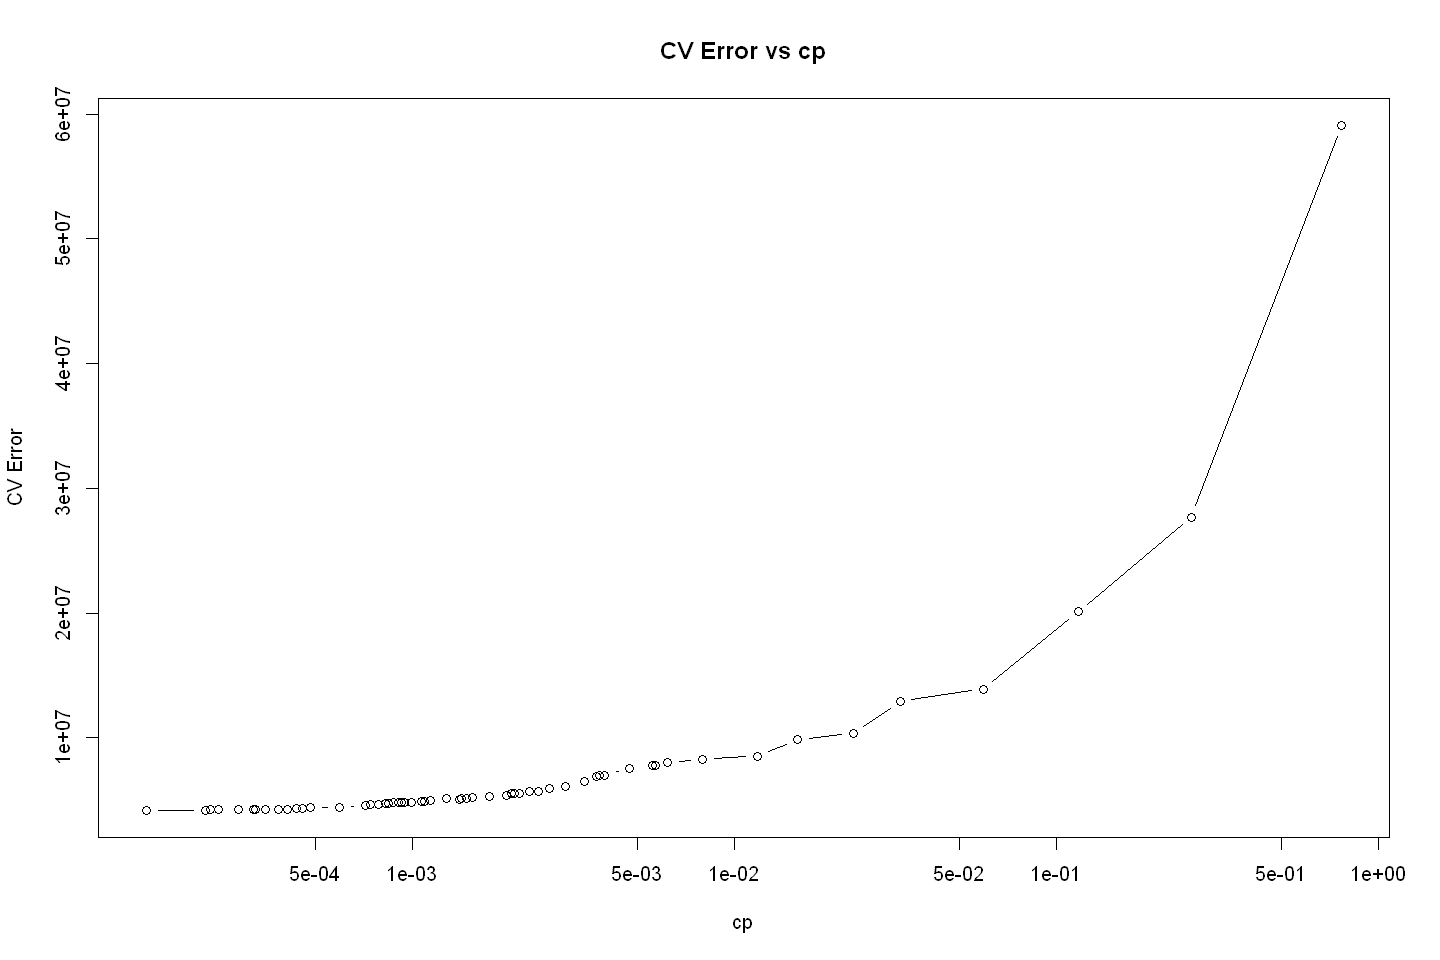

In [6]:
plot(as.numeric(names(CVerr)), CVerr, type = "b", xlab = "cp", ylab = "CV Error", main = "CV Error vs cp", log = "x")

[1] 0.0001485483

Warning message:
"labs do not fit even at cex 0.15, there may be some overplotting"


Number of nodes:  115 


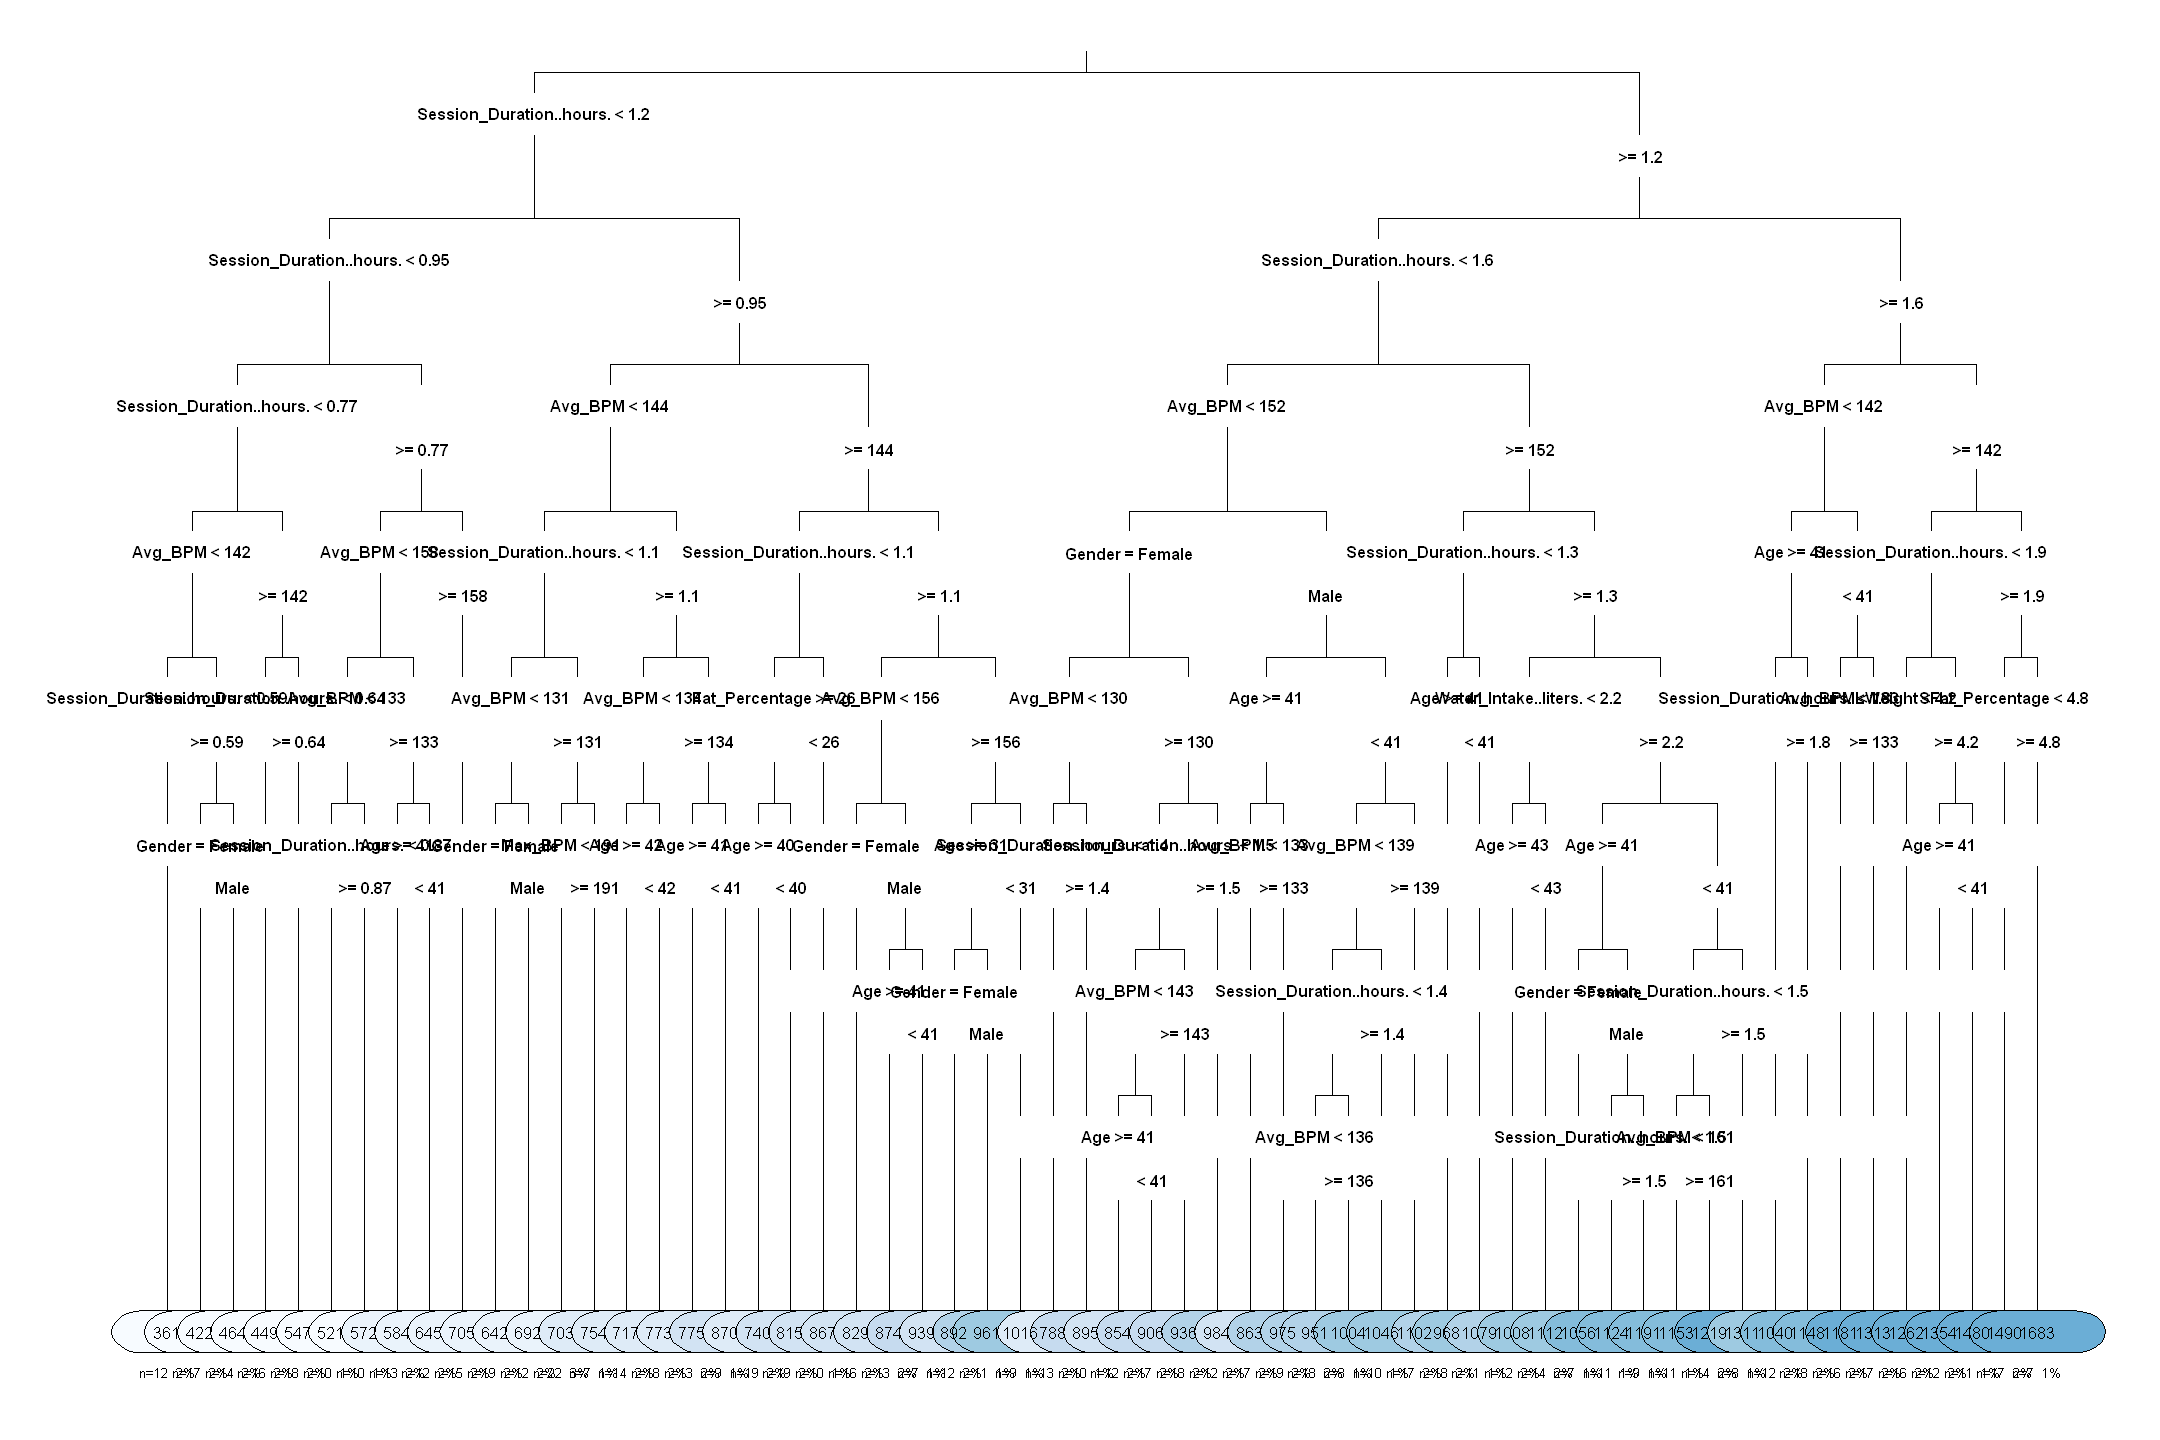

In [7]:
options(repr.plot.width=18, repr.plot.height=12)
as.numeric(attributes(which.min(CVerr))$names)
tree.reg.cal <- rpart(Calories_Burned ~ ., data = gym_train, control=rpart.control(cp=as.numeric(attributes(which.min(CVerr))$names)))

# Plot the tree
rpart.plot(tree.reg.cal, extra = 101, type = 3, under = TRUE, cex = 0.8, tweak = 1)

# display the number of nodes of the treee
cat("Number of nodes: ", length(tree.reg.cal$frame$var), "\n")

**Interprétation** : La validation croisée 10-fold a identifié une pénalité optimale inattendue (`cp ≈ 0.00015`), conduisant à une erreur de validation (MSE ≈ 4521) inférieure aux modèles moins complexes. Ce résultat paradoxal – où réduire `cp` améliore la performance en validation – pourrait s'expliquer par :
- La présence d'interactions complexes dans les données, nécessitant une structure arborescente fine pour être capturées,
- Un biais de sélection lié à l'échantillon, où le sur-apprentissage partiel reste généralisable.

Le premier point est peu probable car le modèle de régression linéaire avec régularisation LASSO a déjà capturé la plupart des interactions significatives. Le second point est plus plausible, suggérant que le modèle a appris des motifs spécifiques à l'échantillon d'entraînement qui se généralisent bien à la validation croisée.

Cependant, l'arbre résultant reste difficilement interprétable (115 nœuds), soulignant un compromis problématique entre performance et explicabilité.

In [8]:
# library(partykit)
# plot(as.party(tree.reg.cal), type="simple")

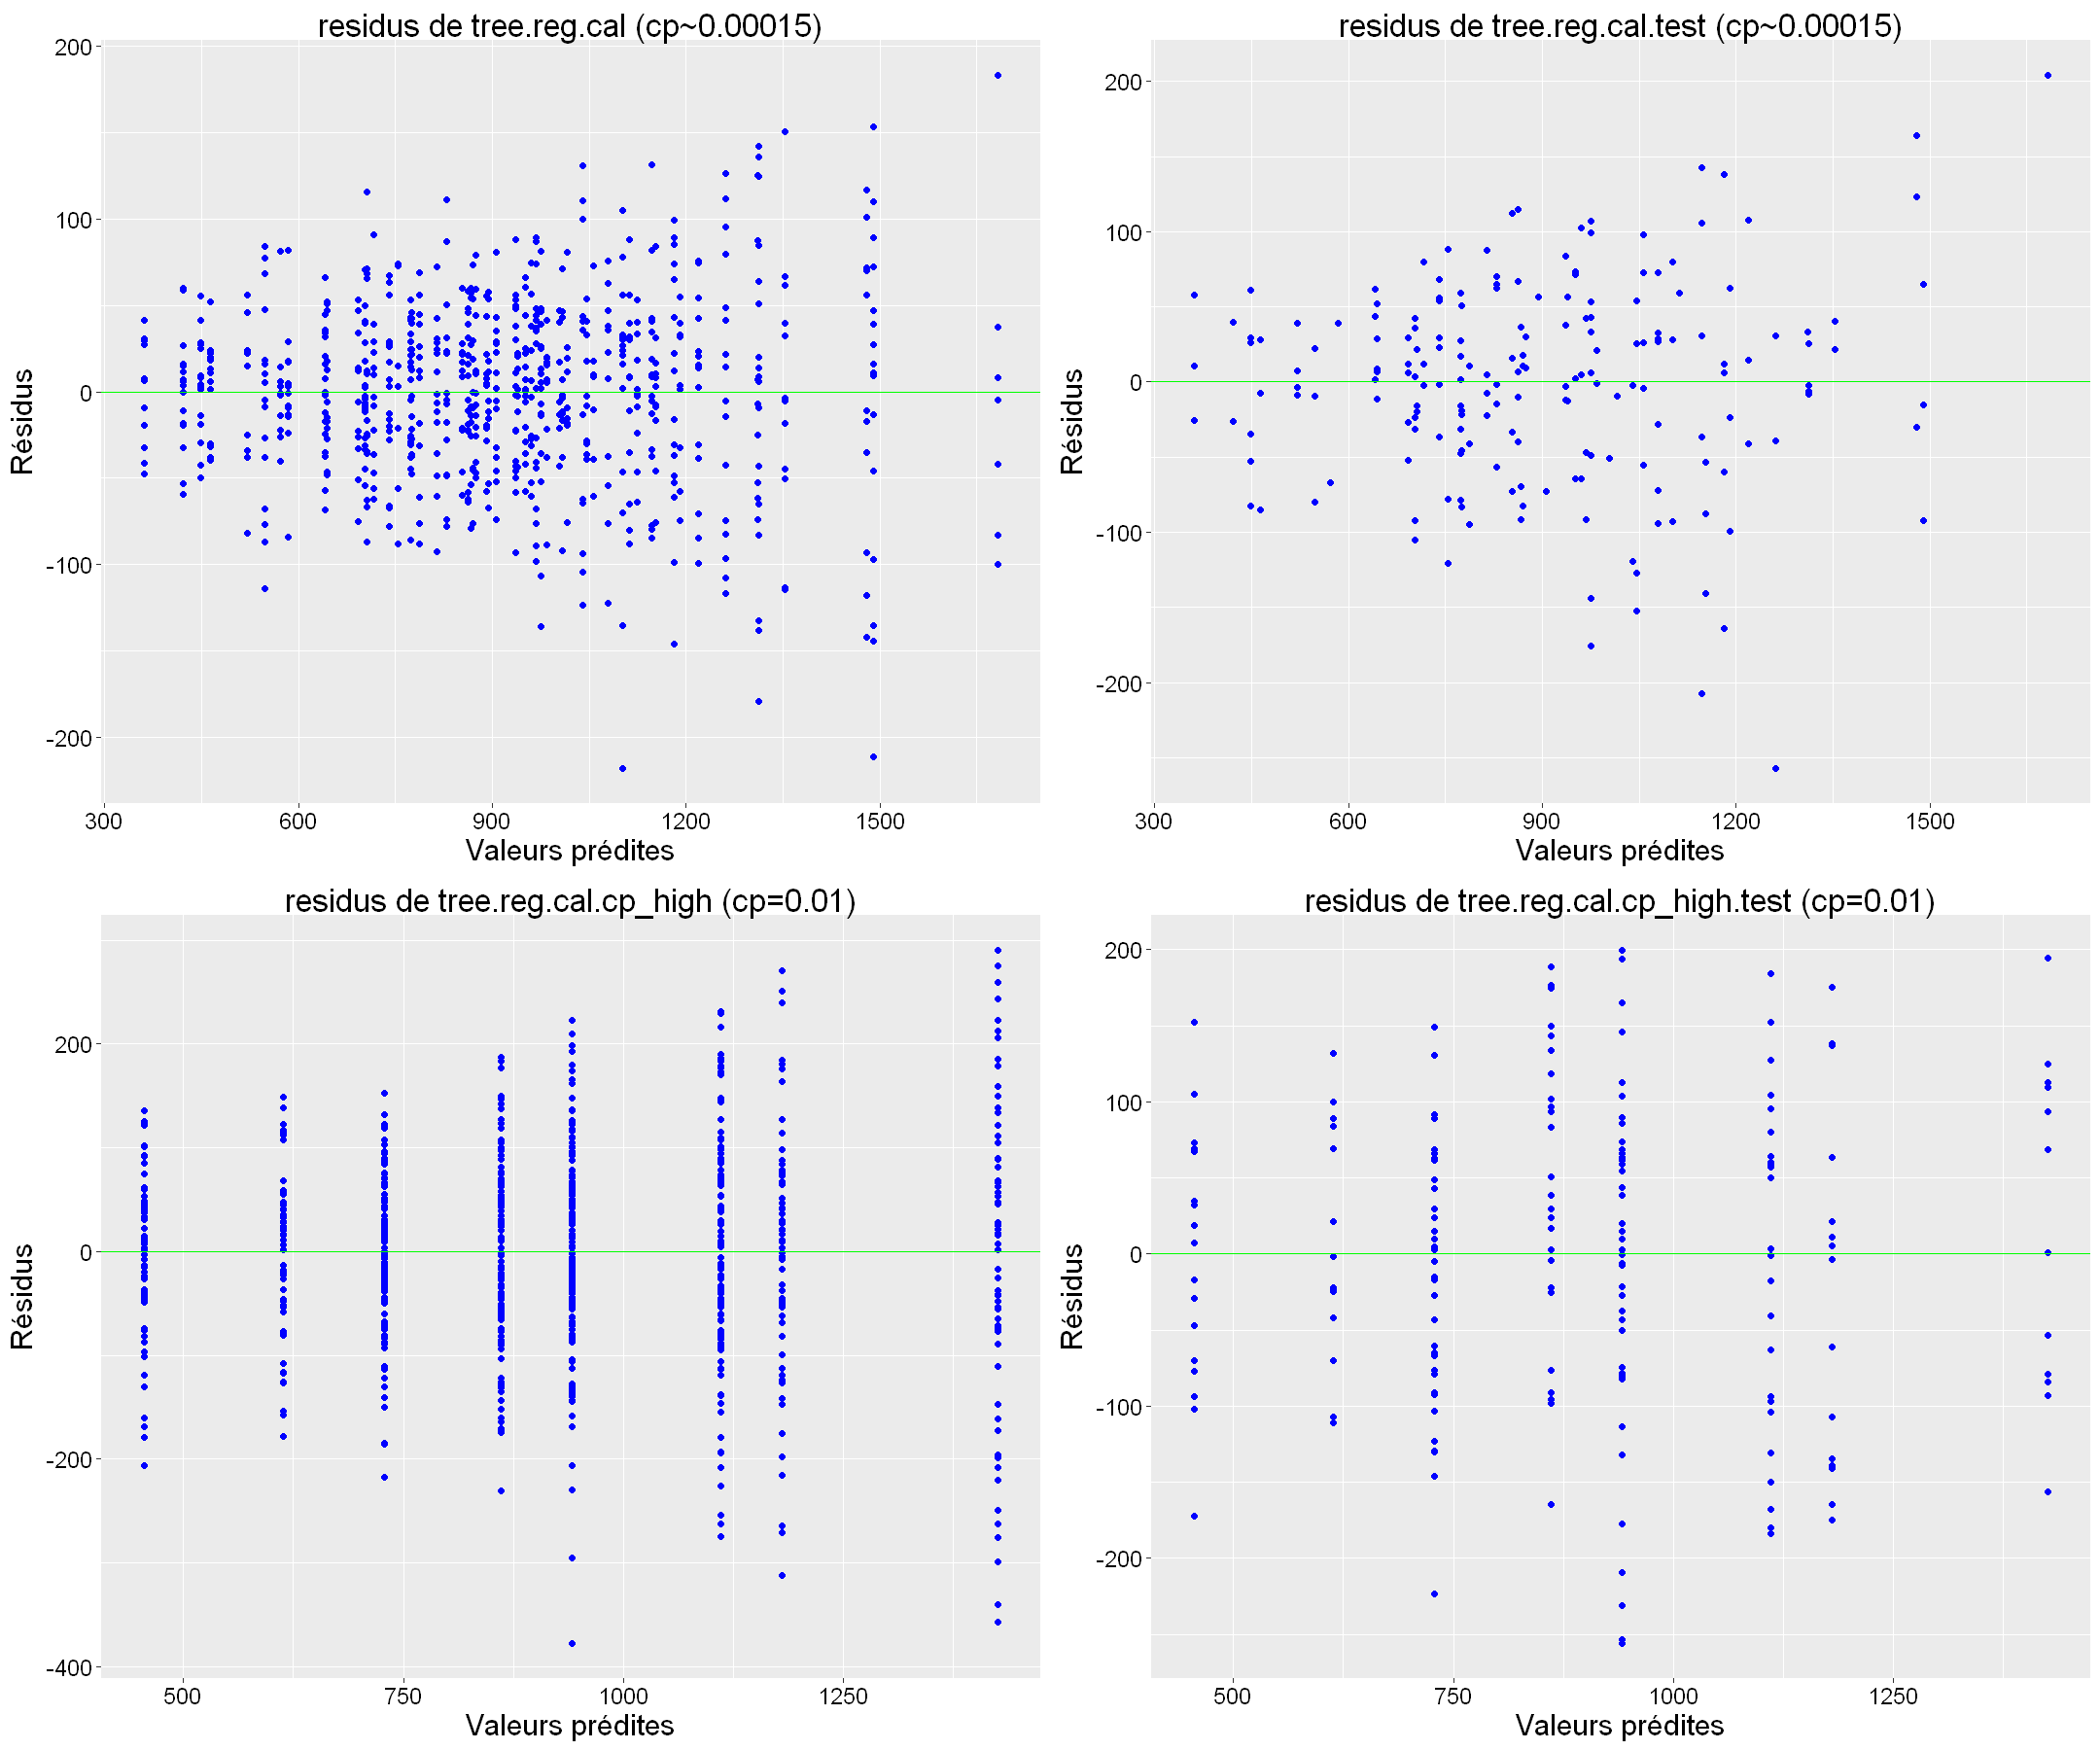

In [9]:
options(repr.plot.width=18, repr.plot.height=15)

fit.tree.cal=predict(tree.reg.cal)
res.tree.cal=fit.tree.cal-gym_train[,"Calories_Burned"]
p1 <- gplot.res(fit.tree.cal,res.tree.cal,"residus de tree.reg.cal (cp~0.00015)")

fit.tree.cal.test=predict(tree.reg.cal, newdata=gym_test)
res.tree.cal.test=fit.tree.cal.test-gym_test[,"Calories_Burned"]
p2 <- gplot.res(fit.tree.cal.test,res.tree.cal.test,"residus de tree.reg.cal.test (cp~0.00015)")

# Create a tree with lower complexity parameter (cp)
tree.reg.cal.cp_high <- rpart(Calories_Burned ~ ., data = gym_train, control=rpart.control(cp=0.01))

fit.tree.cal.cp_high=predict(tree.reg.cal.cp_high)
res.tree.cal.cp_high=fit.tree.cal.cp_high-gym_train[,"Calories_Burned"]
p3 <- gplot.res(fit.tree.cal.cp_high,res.tree.cal.cp_high,"residus de tree.reg.cal.cp_high (cp=0.01)")
fit.tree.cal.cp_high.test=predict(tree.reg.cal.cp_high, newdata=gym_test)
res.tree.cal.cp_high.test=fit.tree.cal.cp_high.test-gym_test[,"Calories_Burned"]
p4 <- gplot.res(fit.tree.cal.cp_high.test,res.tree.cal.cp_high.test,"residus de tree.reg.cal.cp_high.test (cp=0.01)")

grid.arrange(p1, p2, p3, p4, ncol = 2)
rm(p1, p2, p3, p4)

In [10]:
# Calculate metrics for tree.reg.cal
mse_train_cal <- mean(res.tree.cal^2)
r2_train_cal <- 1 - mean(res.tree.cal^2) / var(gym_train[,"Calories_Burned"])

res.tree.cal.test <- predict(tree.reg.cal, newdata = gym_test)
mse_test_cal <- mean((res.tree.cal.test - gym_test[,"Calories_Burned"])^2)
rss_cal <- sum((res.tree.cal.test - gym_test[,"Calories_Burned"])^2)
tss_cal <- sum((gym_test[,"Calories_Burned"] - mean(gym_test[,"Calories_Burned"]))^2)
r2_test_cal <- 1 - rss_cal / tss_cal

# Calculate metrics for tree.reg.cal.cp_high
mse_train_cal_cp_high <- mean(res.tree.cal.cp_high^2)
r2_train_cal_cp_high <- 1 - mean(res.tree.cal.cp_high^2) / var(gym_train[,"Calories_Burned"])

res.tree.cal.cp_high.test <- predict(tree.reg.cal.cp_high, newdata = gym_test)
mse_test_cal_cp_high <- mean((res.tree.cal.cp_high.test - gym_test[,"Calories_Burned"])^2)
rss_cal_cp_high <- sum((res.tree.cal.cp_high.test - gym_test[,"Calories_Burned"])^2)
r2_test_cal_cp_high <- 1 - rss_cal_cp_high / tss_cal

# Create a summary table
results <- data.frame(
    Model = c("tree.reg.cal", "tree.reg.cal.cp_high"),
    MSE_Train = c(mse_train_cal, mse_train_cal_cp_high),
    MSE_Test = c(mse_test_cal, mse_test_cal_cp_high),
    R2_Train = c(r2_train_cal, r2_train_cal_cp_high),
    R2_Test = c(r2_test_cal, r2_test_cal_cp_high)
)

# Print the table
print(results)


                 Model MSE_Train  MSE_Test  R2_Train   R2_Test
1         tree.reg.cal  2613.292  4521.336 0.9655021 0.9339557
2 tree.reg.cal.cp_high  9733.390 10097.079 0.8715101 0.8525094


**Interprétation** : Le modèle complexe (`cp = 0.00015`) montre des résidus mieux centrés et moins dispersés que le modèle élagué (`cp = 0.01`), avec des métriques favorables (R²_test = 0.934 vs 0.853). Toutefois, ces résultats masquent deux risques critiques :
1. Strucutre instable : Une légère perturbation des données pourrait altérer radicalement la structure et la hierarchie des nœuds,
2. Robustesse incertaine : La performance pourrait se dégrader sur des jeux de données déséquilibrés ou non stationnaires.

Pour lever ces doutes, une validation complémentaire par bootstrap (échantillonnage Monte Carlo) serait nécessaire afin d'étudier la variabilité des partitions de l'arbre.

**Bilan** :
Ces résultats paradoxaux – un modèle clairement surappris mais conservant un pouvoir prédictif élevé – suggère deux hypothèses : 
1. Signal fort dans les données : Les variables explicatives contiennent des relations structurelles robustes (linéaires ou non-linéaires), qui seraient généralisables même avec un arbre très complexe.  
2. Limites du sur-apprentissage arborescent : Contrairement à d’autres méthodes (ex : réseaux de neurones), les arbres surappris peuvent rester partiellement interprétables et éviter un effondrement complet en généralisation. 

Néanmoins, la supériorité du modèle linéaire (R²_test = 0.98) remet en question la pertinence de la complexité de l'arbre. Si la relation sous-jacente est majoritairement linéaire, l’arbre introduit un biais de variance inutile. Cette observation plaide pour une analyse comparative approfondie entre modèles linéaires et non linéaires.

Pour conclure, bien que l’arbre complexe ne soit pas optimal (sur-apprentissage avéré et performance inférieure au linéaire), sa robustesse relative en généralisation (R²_test = 0.93) souligne la présence de motifs prédictifs stables dans les données. Ce résultat justifie une exploration des méthodes hybrides (ex : forêts aléaires avec régularisation, XGBoost) pour concilier flexibilité non linéaire et stabilité.

### Random Forests and Boosting
- Random forests with `mtry` and Brieman criterion
- Regularization with Boosting
- Using Bootsratp
- **plot** feature importance

#### Simple Random Forest

In [27]:
library(randomForest)

In [28]:
rf.reg.cal <- randomForest(Calories_Burned ~ ., data = gym_train,
 xtest = gym_test[, -9], ytest = gym_test[, "Calories_Burned"],
 ntree=500,do.trace=50,importance=TRUE, keep.forest = TRUE)

attributes(rf.reg.cal)

cat("mtry = ", rf.reg.cal$mtry)

     |      Out-of-bag   |       Test set    |
Tree |      MSE  %Var(y) |      MSE  %Var(y) |
  50 |     4125     5.45 |     3236     4.73 |
 100 |     3962     5.24 |     3297     4.82 |
 150 |     3796     5.02 |     3273     4.78 |
 200 |     3722     4.92 |     3309     4.83 |
 250 |     3622     4.79 |     3225     4.71 |
 300 |     3572     4.72 |     3174     4.64 |
 350 |     3544     4.68 |     3204     4.68 |
 400 |     3552     4.69 |     3228     4.72 |
 450 |     3565     4.71 |     3255     4.75 |
 500 |     3562     4.71 |     3221     4.71 |


$names
 [1] "call"            "type"            "predicted"       "mse"            
 [5] "rsq"             "oob.times"       "importance"      "importanceSD"   
 [9] "localImportance" "proximity"       "ntree"           "mtry"           
[13] "forest"          "coefs"           "y"               "test"           
[17] "inbag"           "terms"          

$class
[1] "randomForest.formula" "randomForest"

mtry =  4

In [112]:
cat("\nOOB MSE train:", mean(rf.reg.cal$mse))
cat("\nMSE test:", mean(rf.reg.cal$test$mse))


OOB MSE train: 3962.742


MSE test: 3338.551

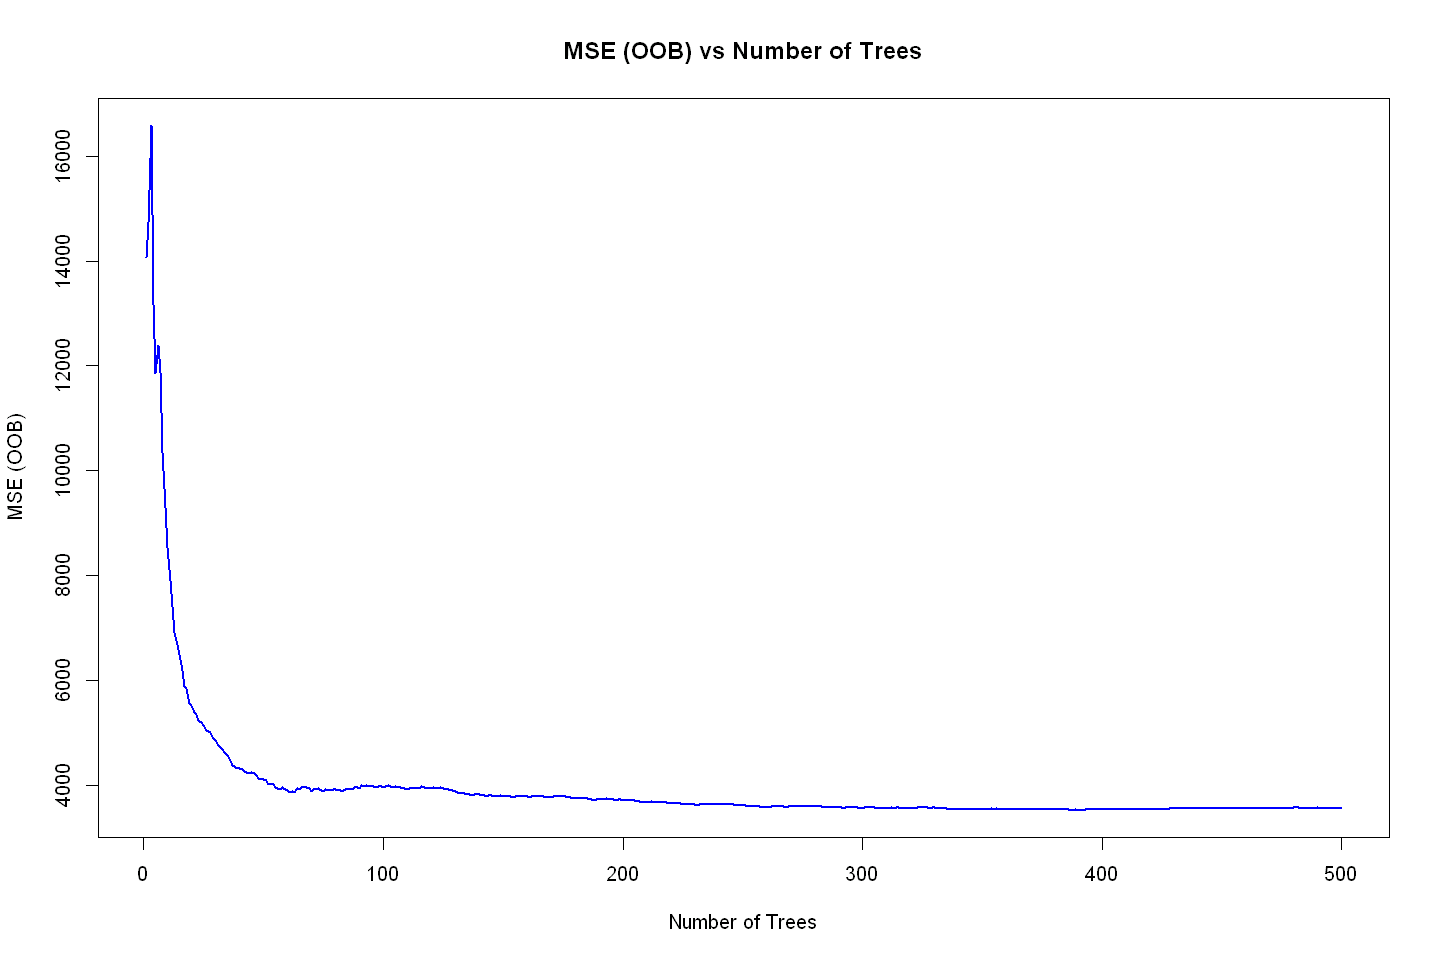

In [30]:
# Plot MSE OOB as a function of the number of trees
options(repr.plot.width=12, repr.plot.height=8)
plot(rf.reg.cal$mse, type = "l", col = "blue", lwd = 2,
    xlab = "Number of Trees", ylab = "MSE (OOB)",
    main = "MSE (OOB) vs Number of Trees")

L'objectif des forets aléatoires est de réduire la variance des arbres tout en conservant leur pouvoir prédictif via le bagging, qui est une technique combinant bootstraping et agrégation d'arbres.

**Paramètres à optimiser** : 
- `mtry`, le nombre de variables tirées aléatoirement à chaque split.
    - **Empiriquement** il est choisi par `mtry ≈ p/3` en régression ou `p` est le nombre total de variables. Ici `p = 14` donc `mtry` vaut logiquement 4.
    - L'optimisation du `mtry` va être réalisé avec la fonction tuneRF qui cherche en partant du `mtry = p/3 = 4` et va essayer avec un mtry plus petit ou plus grand selon comment varie l'erreur de généralisation Out-Of-Bag (OOB). Il s'arrête dès qu'une amélioration de cette erreur OOB est inférieure à 5% (par défaut).
- `ntree`, le nombre d'arbre dans la forêt. Il varie de 100 à 500 et les gains sont marginaux au-delà.

##### Optimisation du `mtry`

mtry = 4  OOB error = 3887.705 
Searching left ...
mtry = 2 	OOB error = 8554.034 
-1.200279 0.01 
Searching right ...
mtry = 8 	OOB error = 2237.759 
0.424401 0.01 
mtry = 13 	OOB error = 2075.662 
0.07243732 0.01 


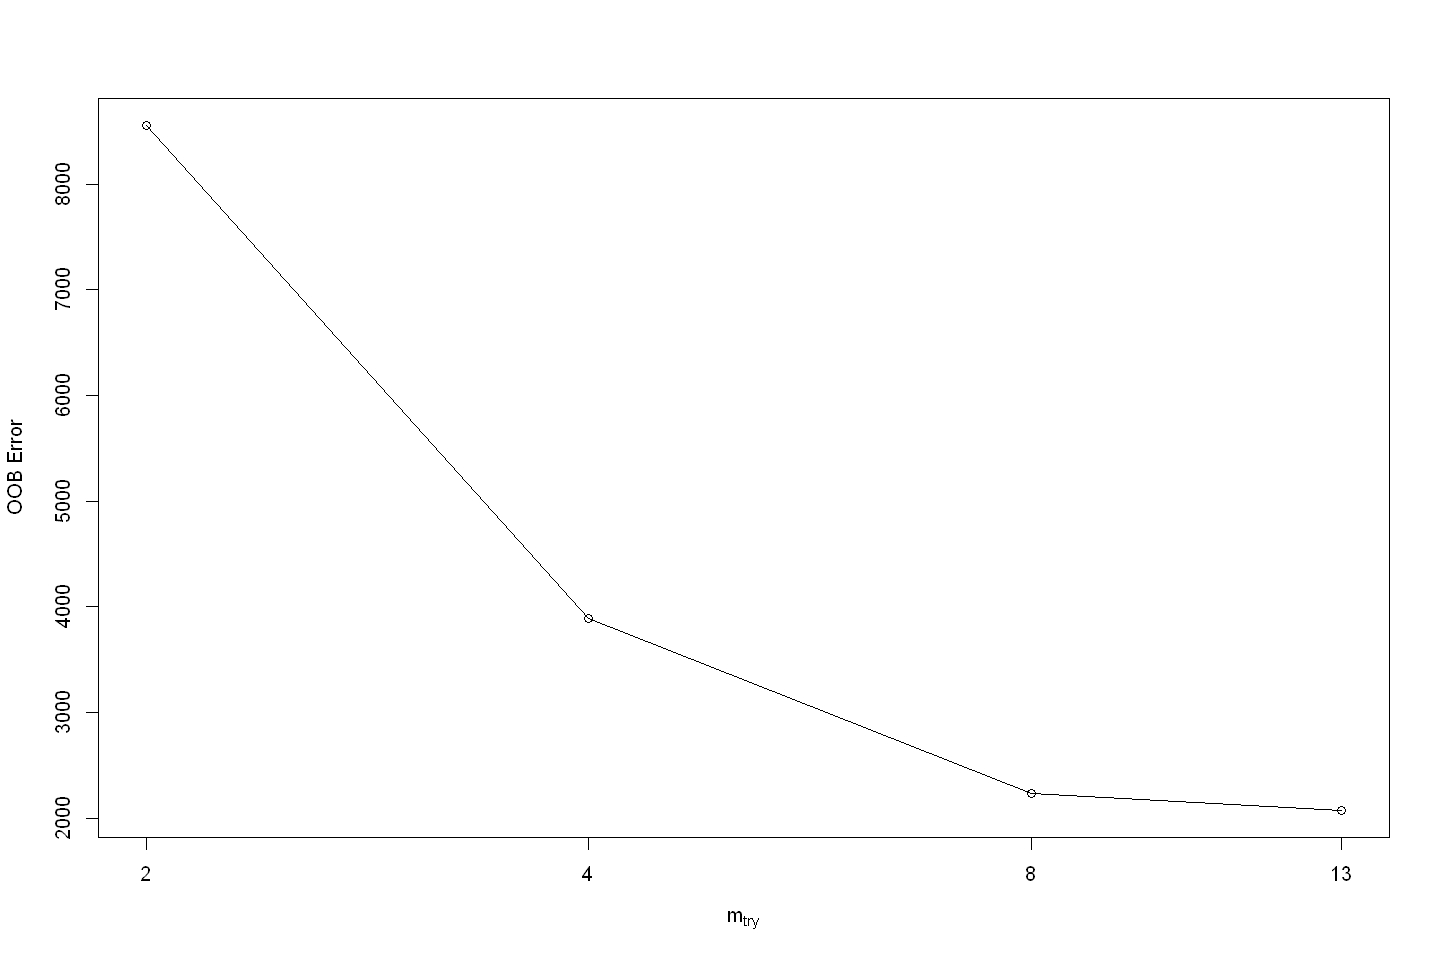

In [31]:
options(repr.plot.width=12, repr.plot.height=8)

rf.reg.cal.tune <- tuneRF(gym_train[,-9], gym_train[,9], ntreeTry = 100,
 improve = 0.01, trace = 50, doBest = TRUE, xtest = gym_test[, -9],
  ytest = gym_test[, "Calories_Burned"])

In [113]:
cat("mtry optimal = ", rf.reg.cal.tune$mtry, "\n")

res.rf.cal <- rf.reg.cal.tune$predicted
r2.rf.cal.train <- 1 - mean(res.rf.cal^2) / tss_cal

res.rf.cal.test <- rf.reg.cal.tune$test$predicted
rss.rf.cal.test <- sum((res.rf.cal.test - gym_test[,"Calories_Burned"])^2)
r2.rf.cal.test <- 1 - rss.rf.cal.test / tss_cal

cat("R2 train :", r2.rf.cal.train, "\n")
cat("R2 test :", r2.rf.cal.test)

mtry optimal =  13 
R2 train : 0.9328115 
R2 test : 0.9784486

In [114]:
cat("OOB MSE train:", mean(rf.reg.cal.tune$mse))
cat("\nMSE test:", mean(rf.reg.cal.tune$test$mse))
cat("\nAmelioration de l'OOB MSE train:", abs(mean(rf.reg.cal.tune$mse) - mean(rf.reg.cal$mse)), "\n")
cat("Amelioration du MSE test:", abs(mean(rf.reg.cal.tune$test$mse) - mean(rf.reg.cal$test$mse)), "\n")

OOB MSE train: 2119.022
MSE test: 1519.253
Amelioration de l'OOB MSE train: 1843.72 
Amelioration du MSE test: 1819.298 


Après optimisation du `mtry`, le R² train et test sont très bons et l'amélioration de l'erreur OOB et du MSE sur l'échantillon de test est significative.

Le `mtry` optimal trouvé par l'algorithme est **13**. Or le nombre de prédicateurs dans notre jeu de données est 13. 
L'alogrithme a donc utilisé tous les prédicteurs pour construire chaque arbre. Cela pourraît indiquer que peu de prédicteurs sont réellement importants pour la prédiction. En effet, si chaque arbre de la forêt a besoin de comparer tous les prédicateurs, c'est qu'il doit sûrement choisir les mêmes à chaque fois, et ce peu importe l'échantillon boostrap choisi. Cela est à vérifier avec l'importance des variables.

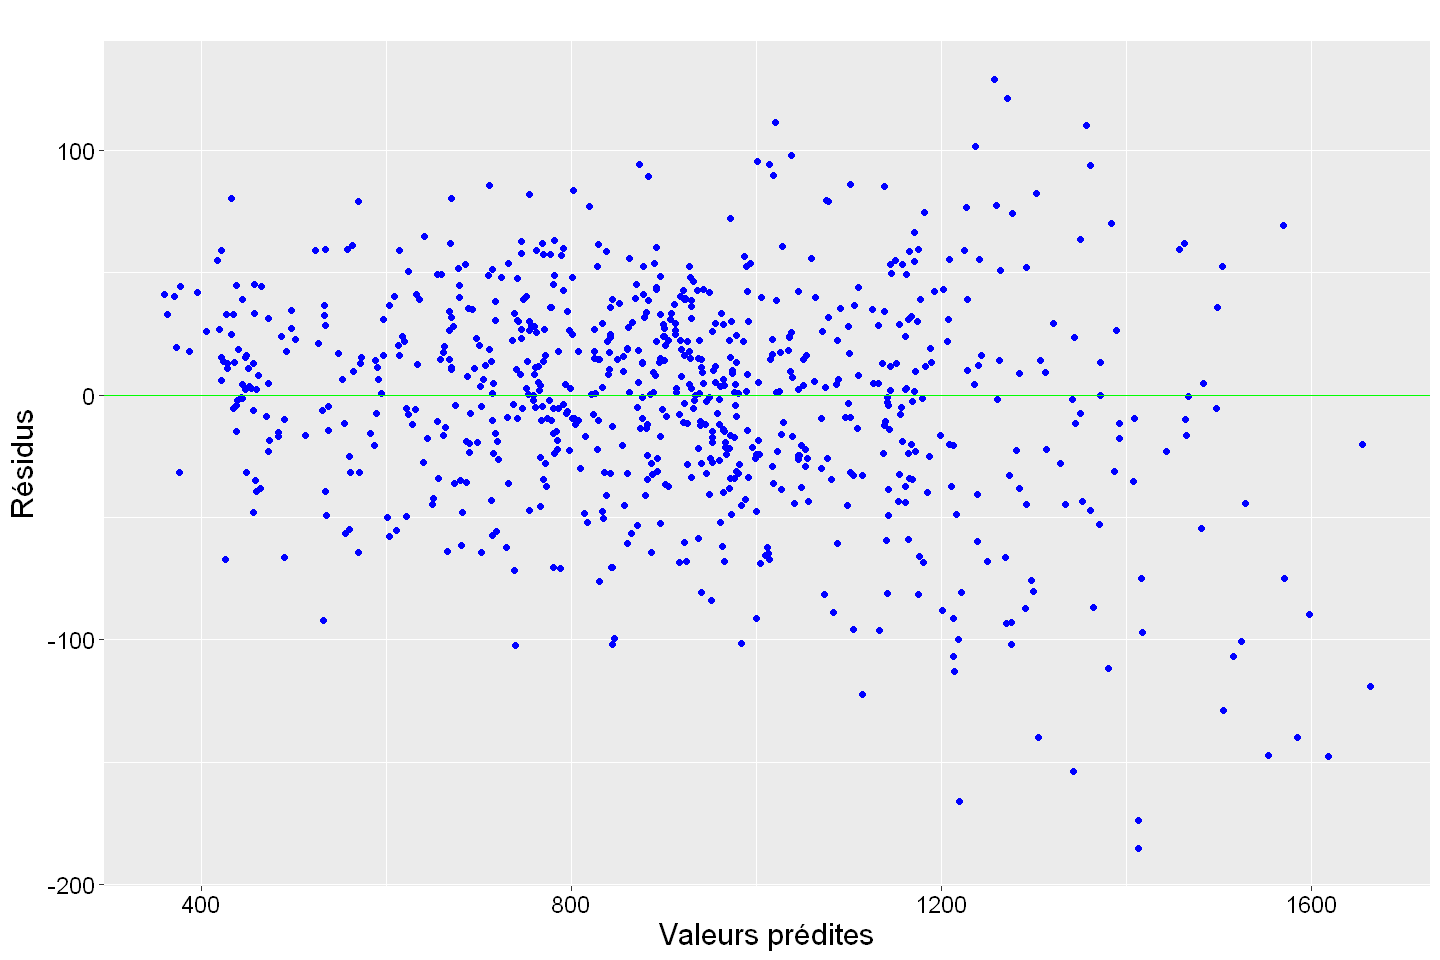

In [35]:
fit.rf.cal.tune <- rf.reg.cal.tune$predicted
res.rf.cal.tune <- fit.rf.cal.tune - gym_train[,"Calories_Burned"]
gplot.res(fit.rf.cal.tune, res.rf.cal.tune, titre="")

**Interprétation** : Le graphique des résidus révèle une performance inégale du modèle selon l’intensité de la dépense calorique. Pour les valeurs modérées (400–1200 calories), les résidus sont centrés et faiblement dispersés ($\pm 100$), attestant d’une prédiction fiable. En revanche, au-delà de 1200 calories, la dispersion des résidus s’accentue significativement, suggérant une difficulté à modéliser les comportements extrêmes. Cette limitation pourrait s’expliquer par la rareté des données pour des séances à dépense calorique ou des interactions non linéaires non capturées. 

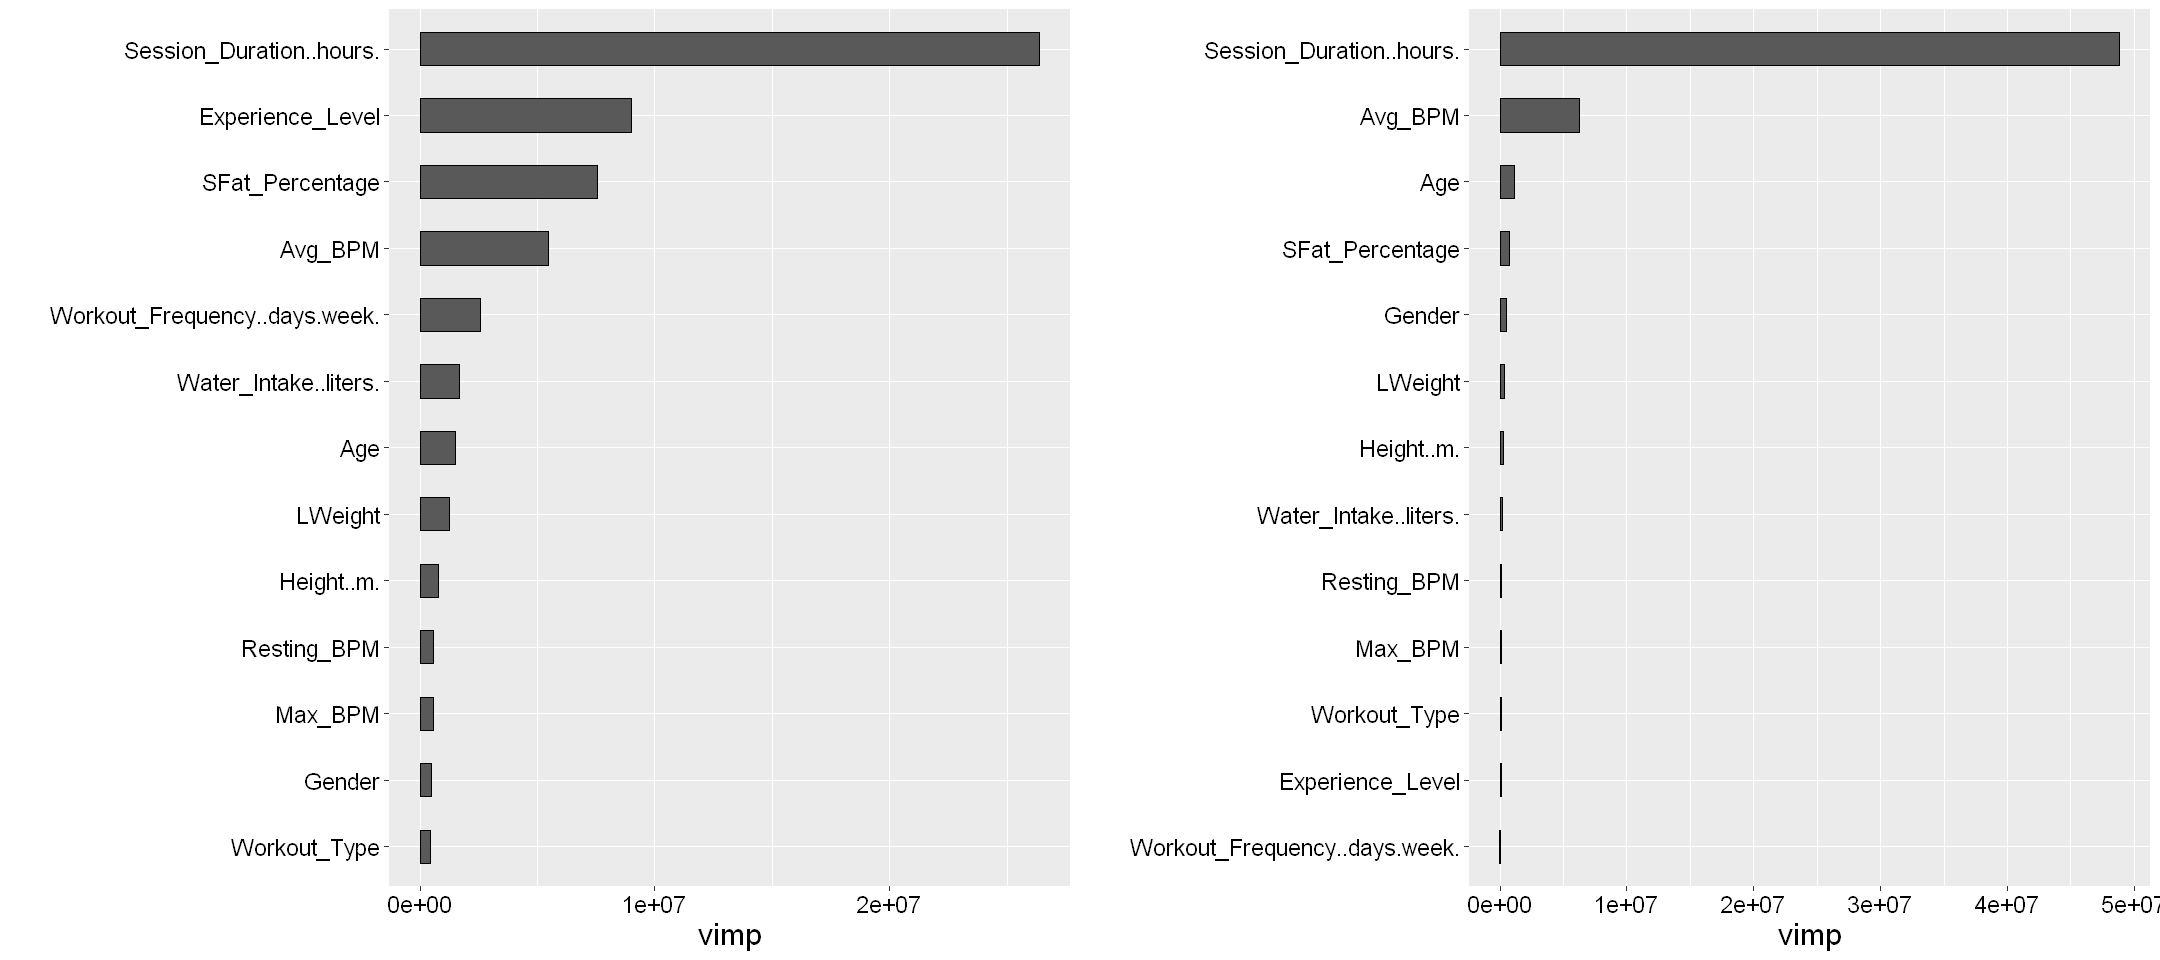

In [36]:
library(ggRandomForests)

options(repr.plot.width=18, repr.plot.height=8)

p1 <- plot(gg_vimp(rf.reg.cal), main = "Importance des variables (mtry = 4)")
p2 <- plot(gg_vimp(rf.reg.cal.tune), main = "Importance des variables (mtry = 13)")

grid.arrange(p1, p2, ncol = 2)
rm(p1, p2)

La comparaison des forêts avec `mtry=4` et `mtry=13` révèle que :
- les prédicateurs `Session_Duration` et `Avg_BPM` sont si fortement liés à la variable cible qu'ils sont selectionnés systématiquement, même lorsque toutes les variables sont disponibles. Ce comportement rappelle les modèles linéaires (Ridge et Lasso) où seules ces variables sont retenues à forte régularisation.
- `Experience_Level` et `SFat_Percentage` n’émergent qu’avec `mtry=4`, suggérant que leurs effets sont liés à des interactions locales.

Le tuning de `mtry=13` simplifie l’interprétation en isolant deux les variables globales, mais la forêt perd en diversité structurelle (les arbres sont plus similaires). En revanche, elle gagne en stabilité prédictive, indiqué par un R²_test = 0.98 et R²_train = 0.92 et une amélioration significative de l'erreur OOB et du MSE sur l'échantillon de test.

Nous allons desormais visualiser les effet marginaux de ces variables sur la prédiction du modèle.

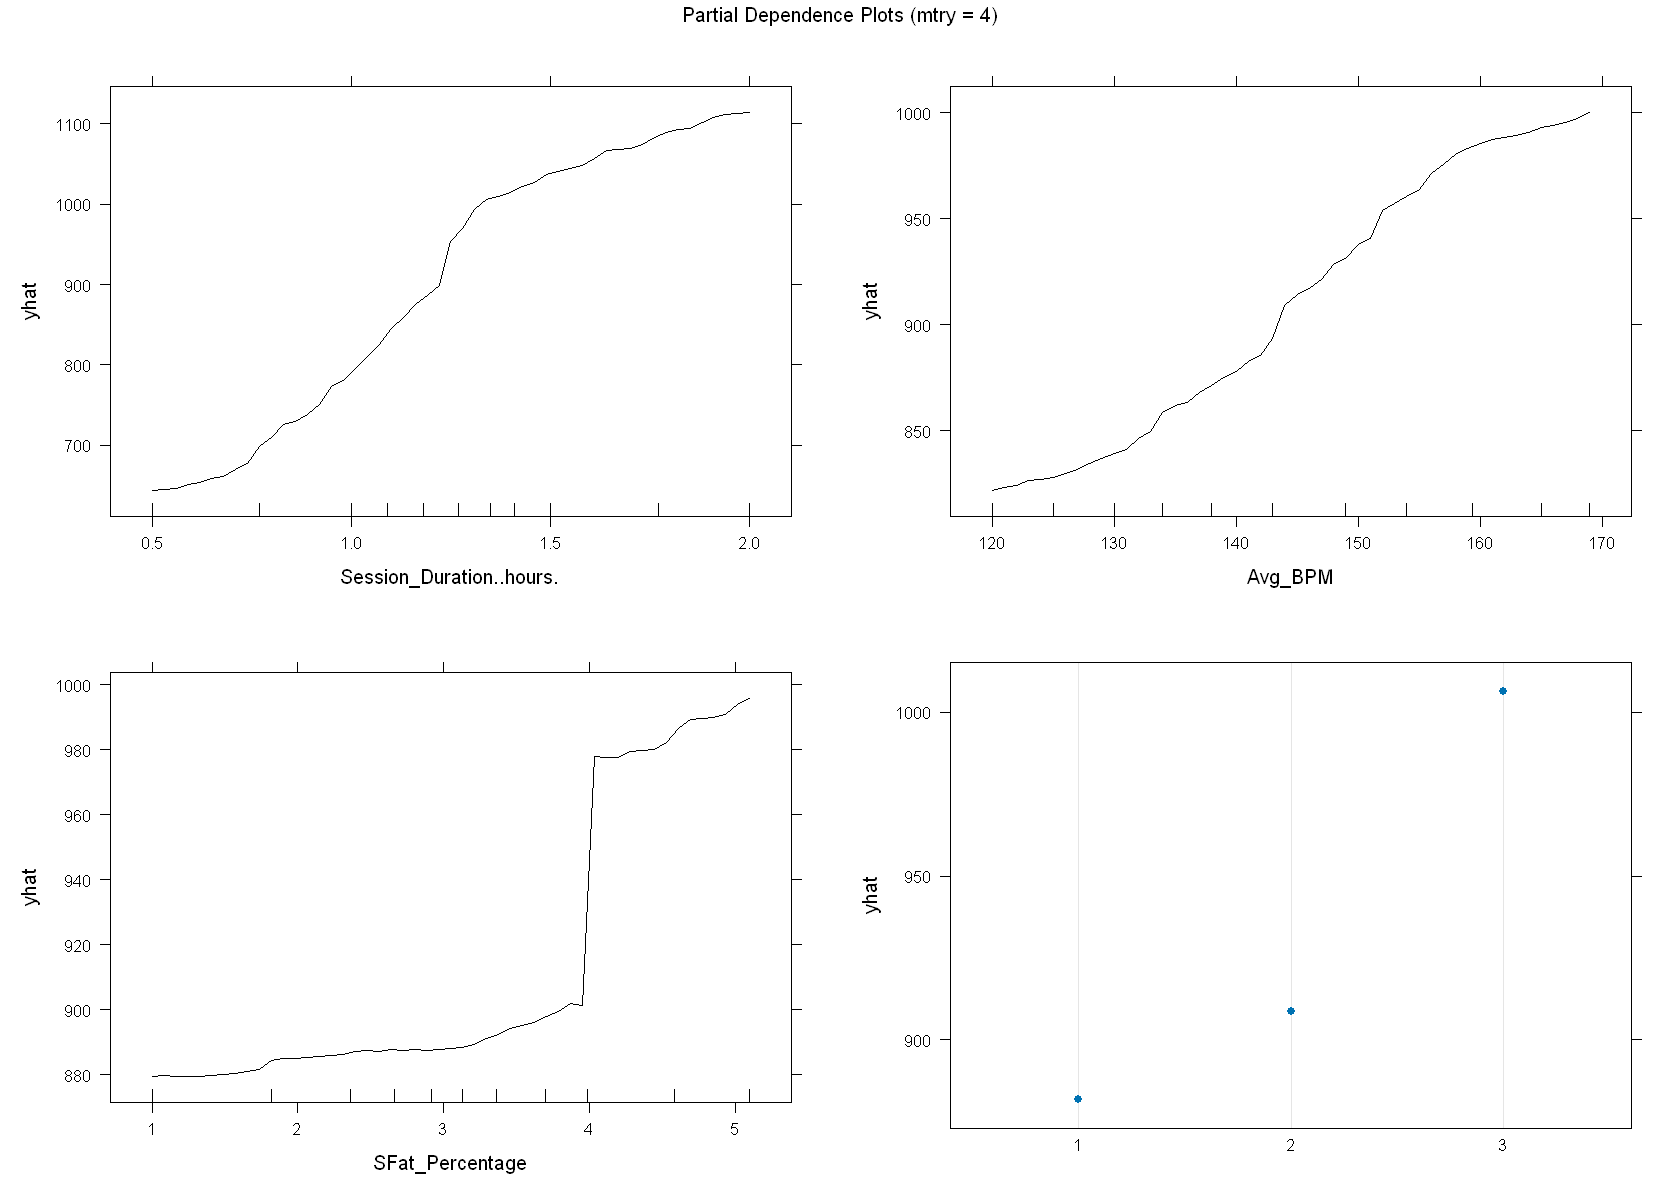

In [ ]:
library(pdp)
p1 <- partial(rf.reg.cal, pred.var = "Session_Duration..hours.", plot = TRUE, rug = TRUE, train=gym_train, type="regression")
p2 <- partial(rf.reg.cal, pred.var = "Avg_BPM", plot = TRUE, rug = TRUE, train=gym_train, type="regression")
p3 <- partial(rf.reg.cal, pred.var = "SFat_Percentage", plot = TRUE, rug = TRUE, train=gym_train, type="regression")
p4 <- partial(rf.reg.cal, pred.var = "Experience_Level", plot = TRUE, rug = TRUE, train=gym_train, type="auto")

options(repr.plot.width=14, repr.plot.height=10)
main = "Partial Dependence Plots (mtry = 4)"
grid.arrange(p1, p2, p3, p4, ncol = 2, top = main)
rm(p1, p2, p3, p4)

**Interpretation des effets marginaux pour `mtry=4`** :

**Effet de `Session_Duration`** : La relation entre la durée de la session et la dépense calorique est positive, avec une pente décroissante. Cela suggère que les premières heures d'entraînement ont un rendement calorique élevé, mais au delà de 1h30 de séance, l'augmentation marginale de la dépense diminue avec le temps. Ce phénomène pourrait être dû à la fatigue ou à l'adaptation physiologique des individus à l'exercice prolongé.

**Effet de `Avg_BPM`** : La frequence cardiaque semble moyenne doit dépasser un certain seuil pour maximiser la dépense énergitique (140-160 bpm). En revanche, on retrouve un léger **effet de plateau** au delà de 160 bpm, suggérant que la dépense calorique n'augmente plus significativement à des niveaux d'intensité cardiaque extrêmes. Cela pourrait être dû aux limites physiologiques du corps humain.

**Effet de `Experience_Level`** : L'expérience des individus a un impact significatif sur la dépense calorique. Les débutants (niveau 1) et intermédiares (niveau 2) ont des dépenses caloriques similaires, mais les experts (niveau 3) semblent avoir une dépense calorique plus élevée. Cela pourrait s'expliquer par une meilleure efficacité de l'entraînement chez les individus expérimentés, qui brûlent plus de calories à un rythme similaire.

**Effet de `SFat_Percentage`** : La transformation appliquée à `Fat_Percentage` (sqrt(max + 1 - x)) complexifie l’interprétation directe. Le pic observé à `SFATPercentage=4` pourrait correspondre à un taux de graisse corporelle optimal pour la dépense énergétique, mais une analyse avec la variable originale est nécessaire pour confirmer cette hypothèse.

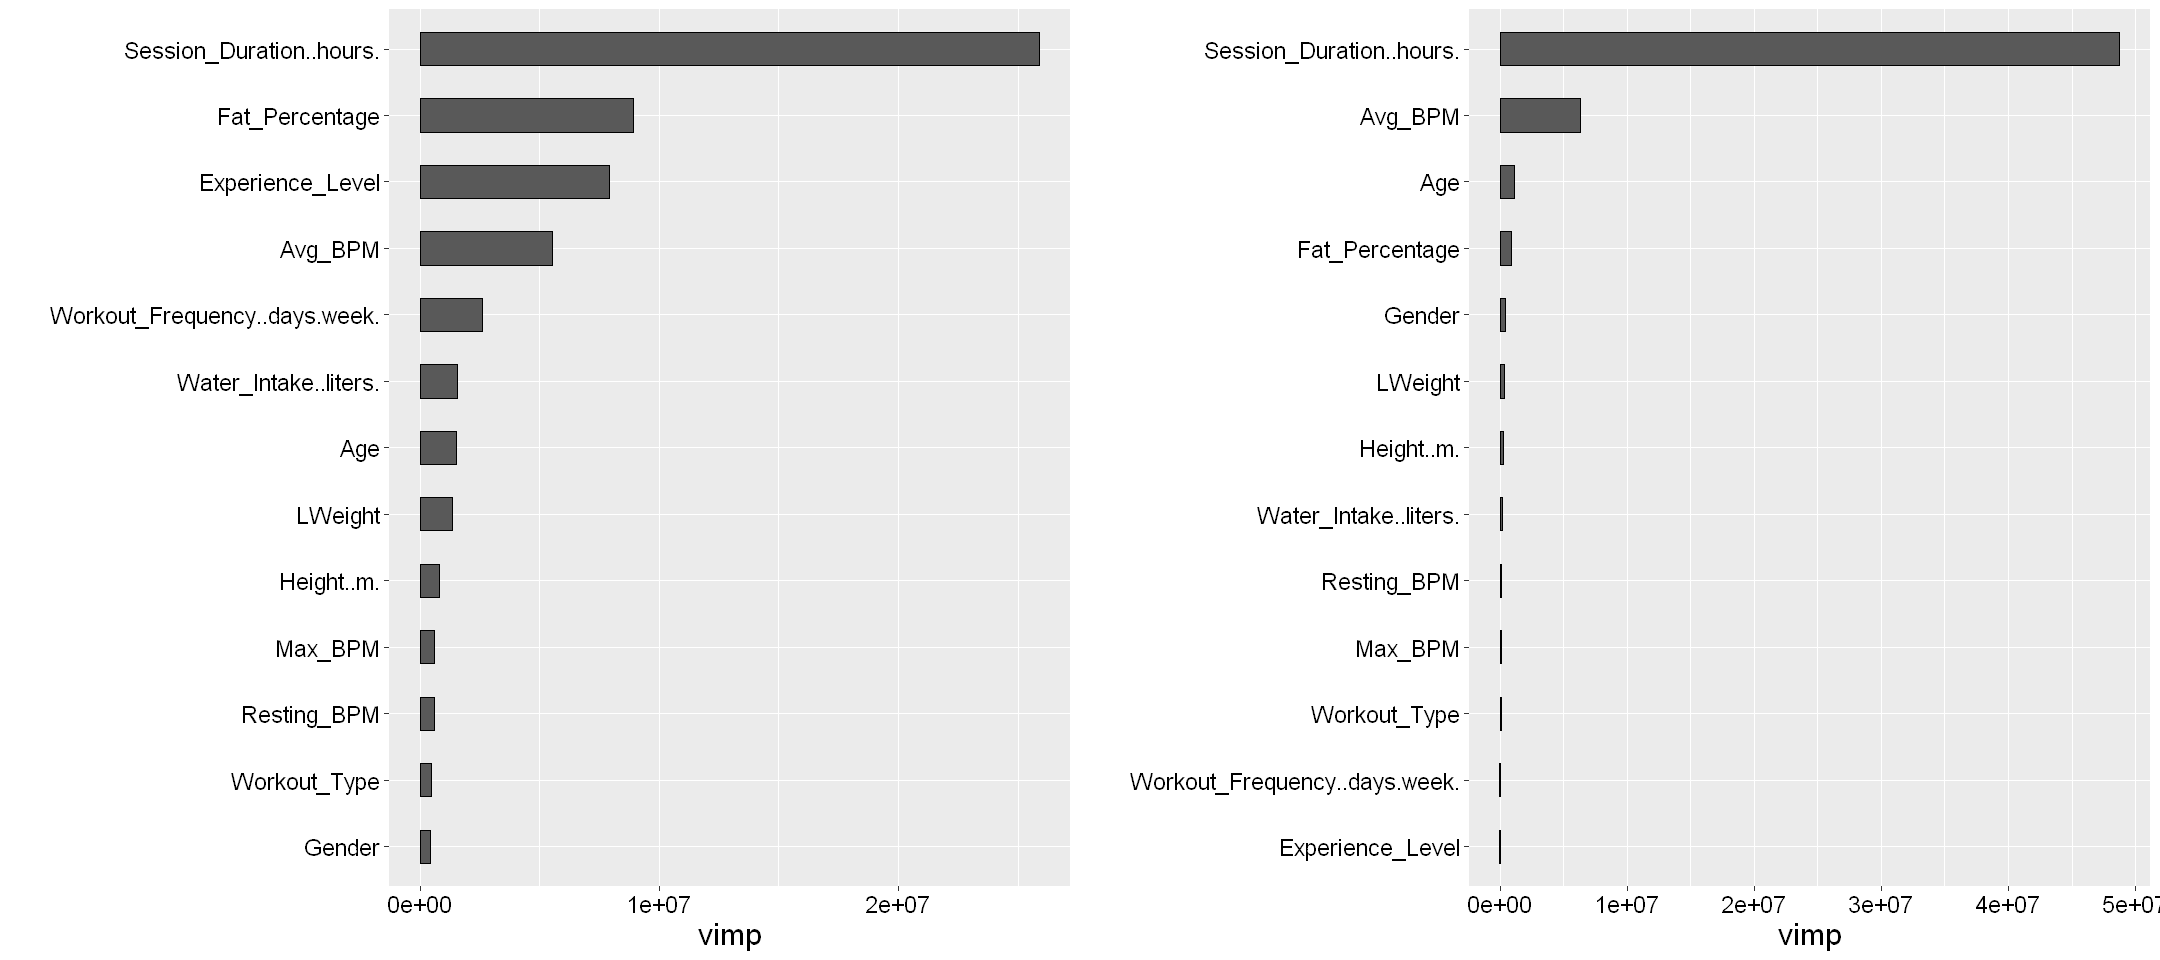

In [143]:
# recreate fat percentage
gym_train[,"Fat_Percentage"] <- (max_fat + 1) - gym_train[,"SFat_Percentage"]^2
gym_test[,"Fat_Percentage"] <- (max_fat + 1) - gym_test[,"SFat_Percentage"]^2

rf.reg.cal.fat_percentage <- randomForest(Calories_Burned ~ ., data = gym_train[, -11],
 xtest = gym_test[, -c(9, 11)], ytest = gym_test[, "Calories_Burned"],
 ntree=500,importance=TRUE, keep.forest = TRUE)

rf.reg.cal.fat_percentage.tune <- randomForest(Calories_Burned ~ ., data = gym_train[, -11],
 ntree=500, mtry=13,
 xtest = gym_test[, -c(9, 11)], ytest = gym_test[, "Calories_Burned"],
 importance=FALSE, keep.forest = TRUE)

# Partial dependence plot for Fat_Percentage
options(repr.plot.width=18, repr.plot.height=8)
# partial(rf.reg.cal.fat_percentage, pred.var = "Fat_Percentage",   rug = TRUE, train=gym_train, type="regression")
p1<-plot(gg_vimp(rf.reg.cal.fat_percentage), main = "Importance des variables (mtry = 4)")
p2<-plot(gg_vimp(rf.reg.cal.fat_percentage.tune), main = "Importance des variables (mtry = 13)")

grid.arrange(p1, p2, ncol = 2)
rm(p1, p2)

**Vérification** : On retrouve bien les même niveaux d'importance de nos variables en ayant interchangé `SFat_Percentage` par `Fat_Percentage` dans le modèle.

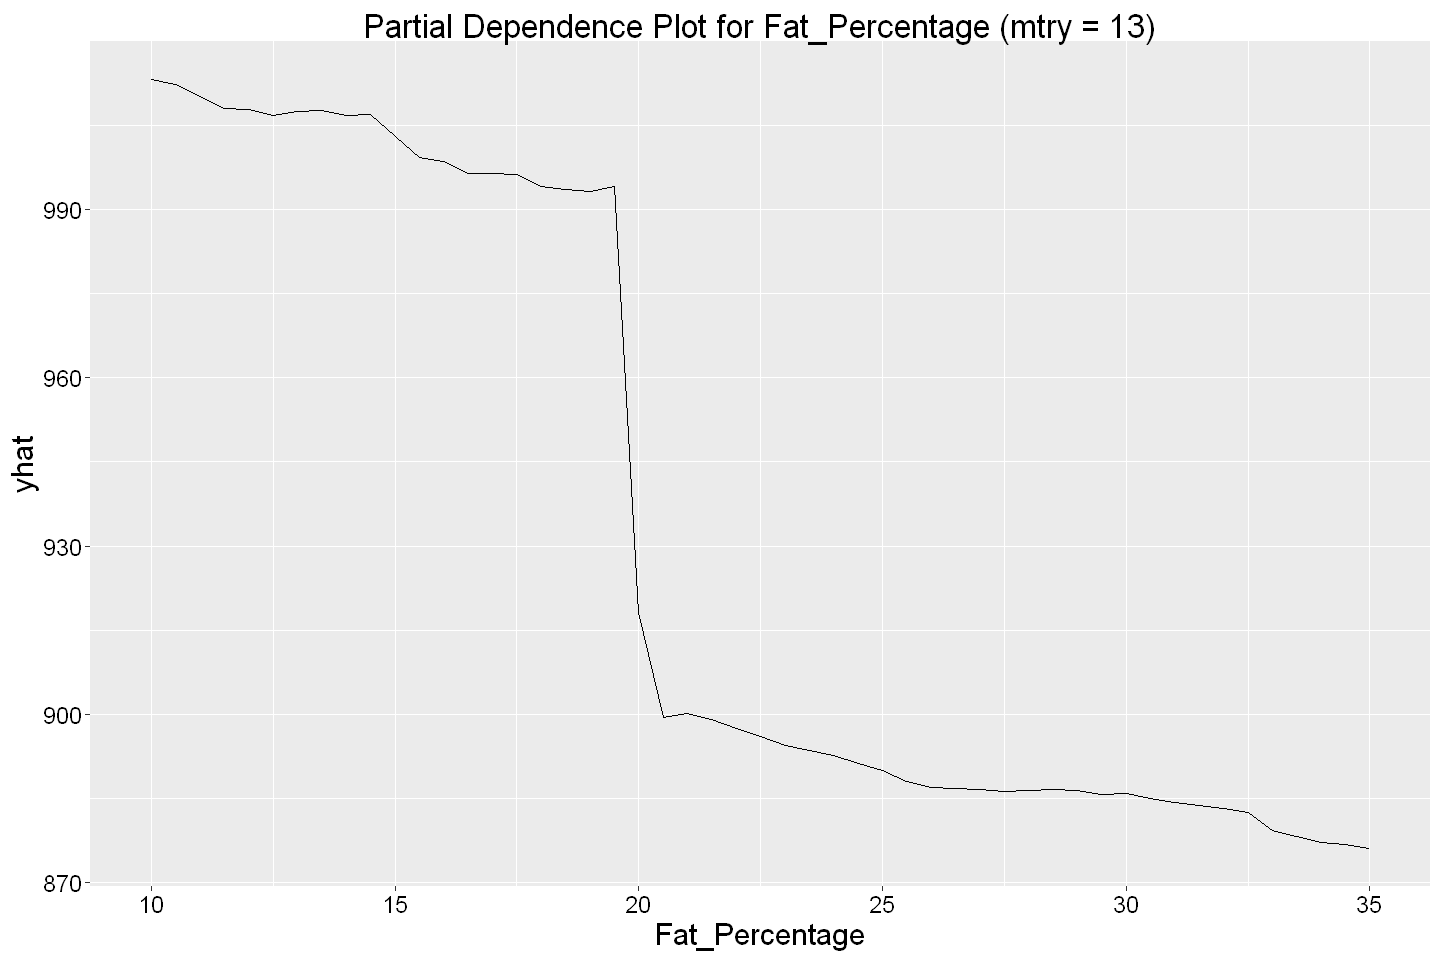

In [144]:
options(repr.plot.width=12, repr.plot.height=8)
autoplot(partial(rf.reg.cal.fat_percentage, pred.var = "Fat_Percentage", rug = TRUE, train=gym_train[], type="regression"),
        main = "Partial Dependence Plot for Fat_Percentage (mtry = 13)")

# delete Fat_Percentage
gym_train <- gym_train %>% select(-c(Fat_Percentage))
gym_test <- gym_test %>% select(-c(Fat_Percentage))


**Interprétation** :

La transformation appliqué à SFat_Percentage inverse artificiellement son echelle :

$$
\text{SFatPercentage} = \sqrt{\max(\text{FatPercentage}) + 1 - \text{FatPercentage}}
$$

Ainsi une valeur élevée de `SFat_Percentage` correspond à un faible taux de masse grasse et inversement.

La forêt detecte une relation **non linéaire** entre le taux de masse grasse et la dépense calorique. On distingue deux groupes d'individus :

- Ceux avec un taux de masse grasse compris entre 10 et 20%.
- Ceux avec un taux de masse grasse compris entre 20 et 35%.

Les individus entre 10 et 20% brûlent environ 100 calories de plus que ceux avec un taux de masse grasse entre 20 et 35%.

Avant d'interpréter ce résultat, il faut observer que la foret avec un `mtry=13` n'a retenu que 2 variables : `Session_Duration` et `Avg_BPM`. Pour rappel, comme on a pu le voir dans l'analyse descriptive et lors de l'Analyse en Composante Principales, la variable `Fat_Percentage` est fortement négativement corrélée avec `Session_Duration`. Sur les graphiques des variables de l'ACP, on a pu observer que `Fat_Percentage` était projeté dans la même direction que `Session_Duration` et `Calories_Burned`. Ce qui montre la redondance entre ces variables pour prédire `Calories_Burned` et donc l'importance de `Session_Duration` pour expliquer la dépense calorique.

**Bilan** : On avait pu déduire que les individus avec un faible taux de masse grasse sont ceux qui s'entraînent le plus longtemps et donc **qui ont la plus forte dépense calorique**. En revanche, les individus avec un taux de masse grasse élevé sont ceux qui s'entraînent le moins longtemps et donc **qui ont la plus faible dépense calorique**. 

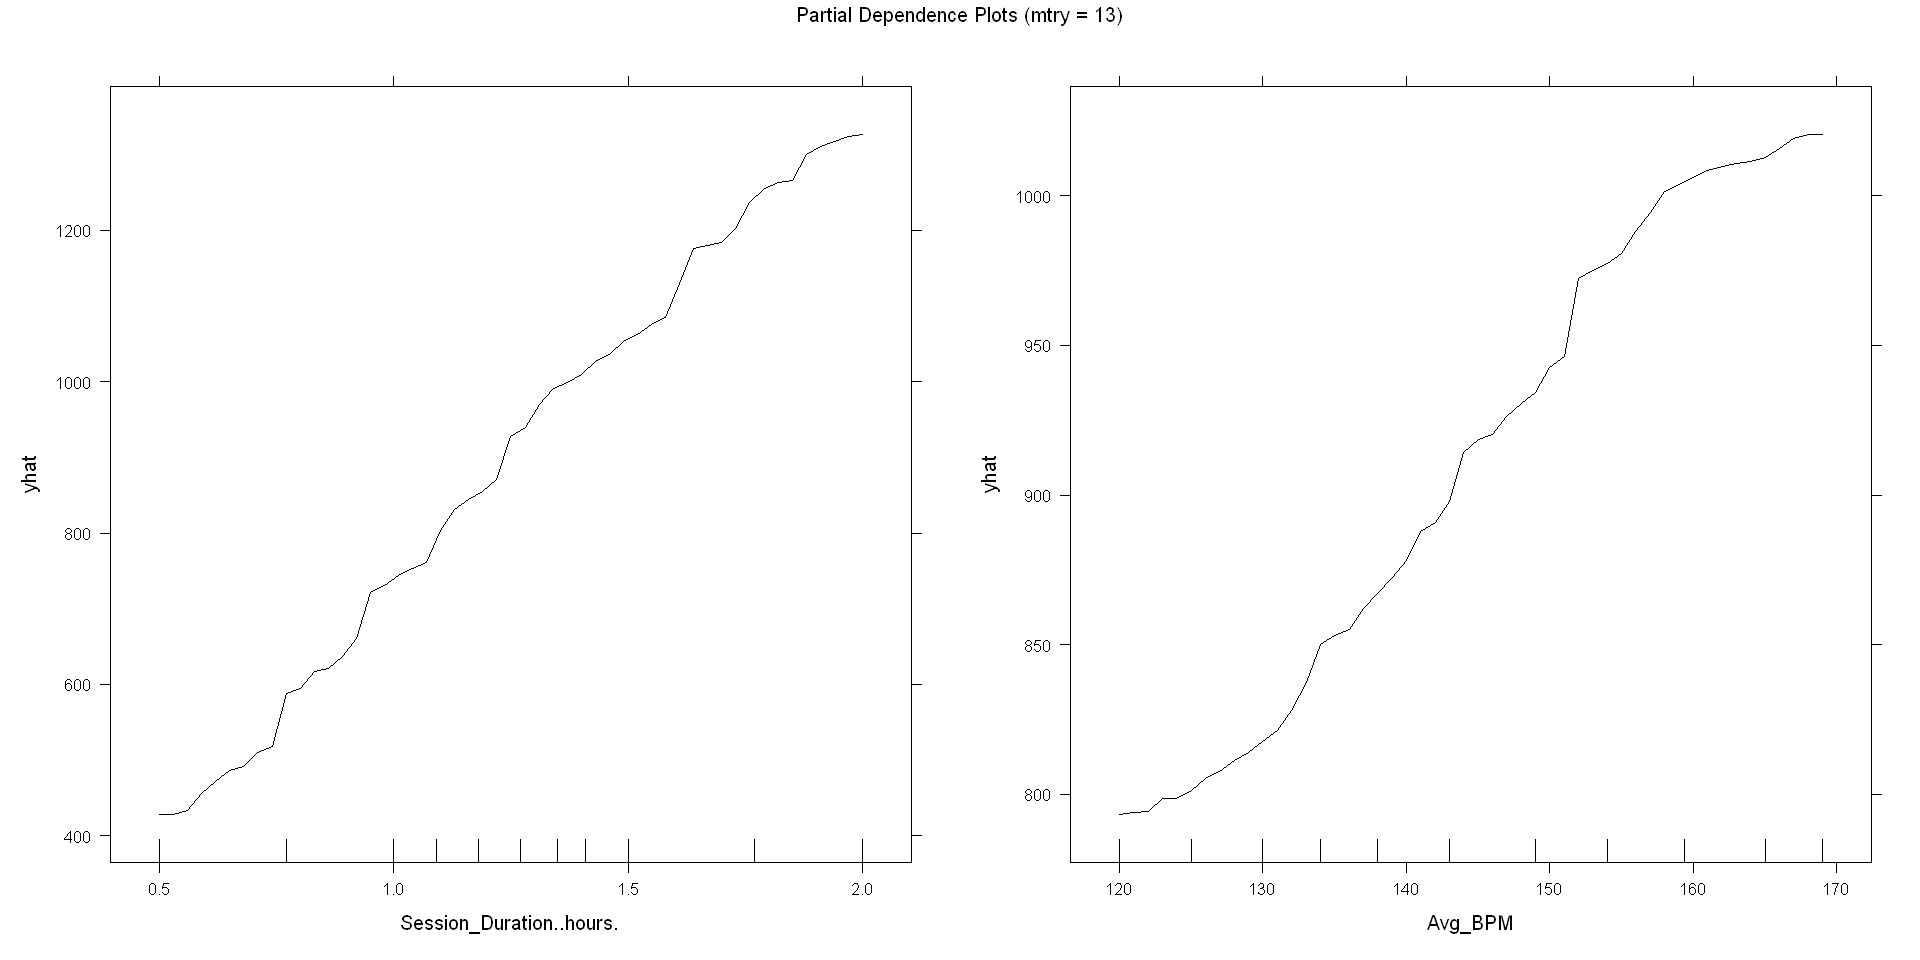

In [23]:
rf.reg.cal.tuned <- randomForest(Calories_Burned ~ ., data = gym_train,
 ntree=100, mtry = 13, importance=TRUE, keep.forest = TRUE)

p1 <- partial(rf.reg.cal.tuned, pred.var = "Session_Duration..hours.", plot = TRUE, rug = TRUE, train=gym_train, type="regression")
p2 <- partial(rf.reg.cal.tuned, pred.var = "Avg_BPM", plot = TRUE, rug = TRUE, train=gym_train, type="regression")

options(repr.plot.width=16, repr.plot.height=8)
main = "Partial Dependence Plots (mtry = 13)"
grid.arrange(p1, p2, ncol = 2, top = main)
rm(p1, p2)

**Interprétation** : 

Le nombre de calories brulées par séance est linéarement lié à la durée de la séance, avec un delta significatif de ~1000 calories entre les séances de 30 minutes et celles de 2h. Pour ce qui est de la fréquence cardiaque moyenne de la séance, on observe la même relation que précedemment, avec un delta plus faible (~200 calories) entre les séances à 120 bpm et celles à 160 bpm.

#### Boosting
Pour améliorer la performance du modèle, nous allons utiliser le boosting, qui consiste à ajuster les erreurs des arbres précédents en ajoutant de nouveaux arbres. Le boosting est particulièrement efficace pour réduire le biais et améliorer la précision des prédictions.

##### Avec la librairie `gbm`

Warning message:
"package 'gbm' was built under R version 4.4.3"


Loaded gbm 2.2.2

This version of gbm is no longer under development. Consider transitioning to gbm3, https://github.com/gbm-developers/gbm3



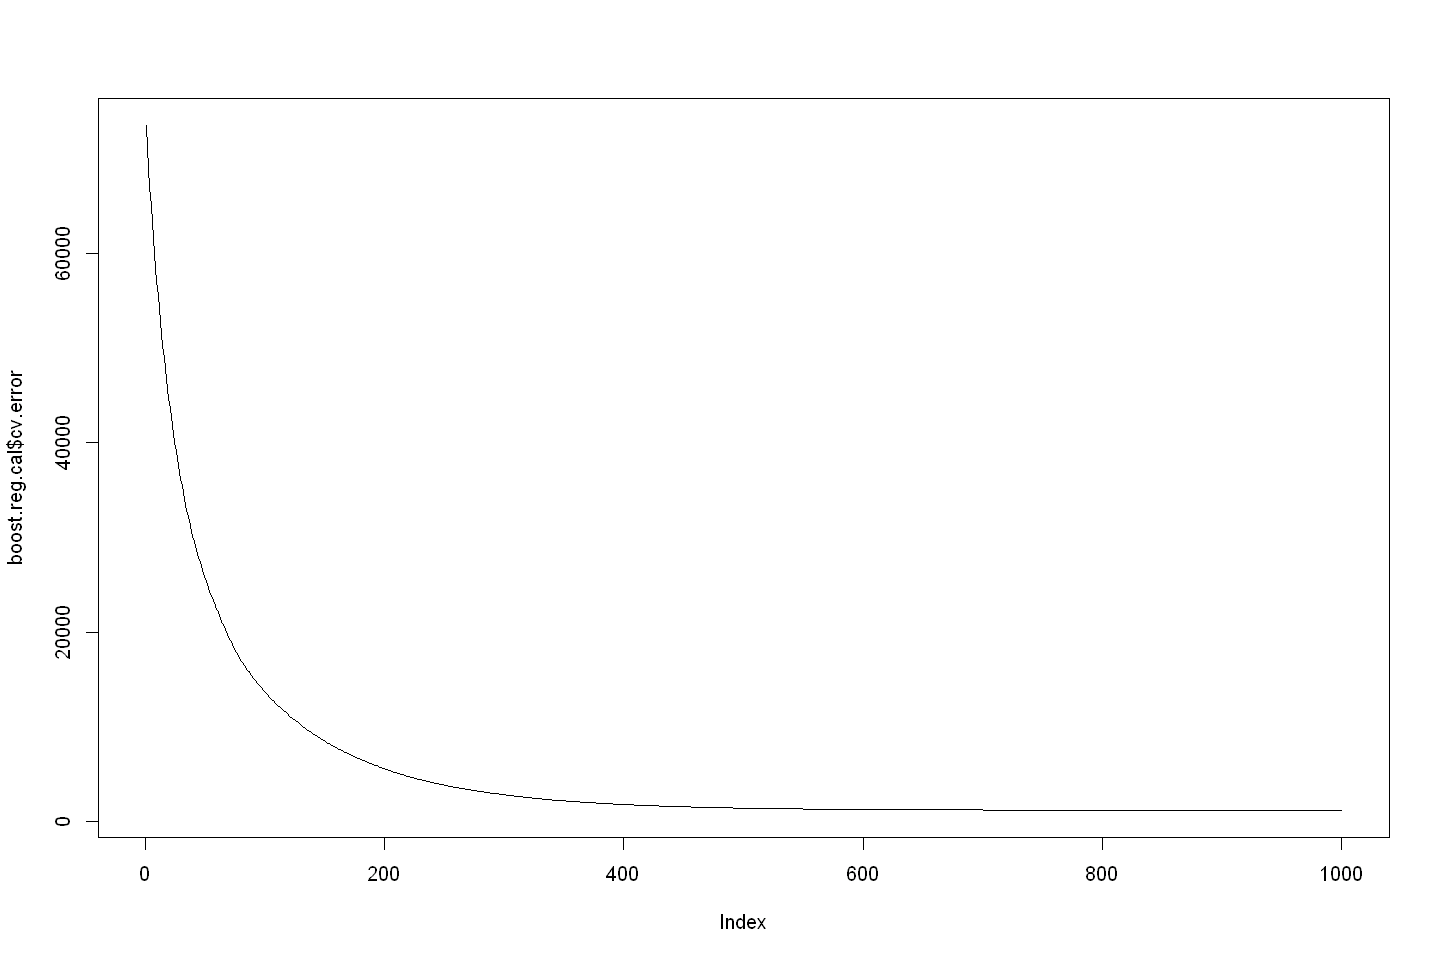

In [ ]:
library(gbm)
options(repr.plot.width=12, repr.plot.height=8)
boost.reg.cal = gbm(Calories_Burned ~ ., data = gym_train, distribution = "gaussian", n.trees = 1000, 
    cv.folds = 10, n.minobsinnode = 5, shrinkage = 0.03, verbose = FALSE)
# verbose à FALSE pour éviter trop de sorties
plot(boost.reg.cal$cv.error, type = "l")

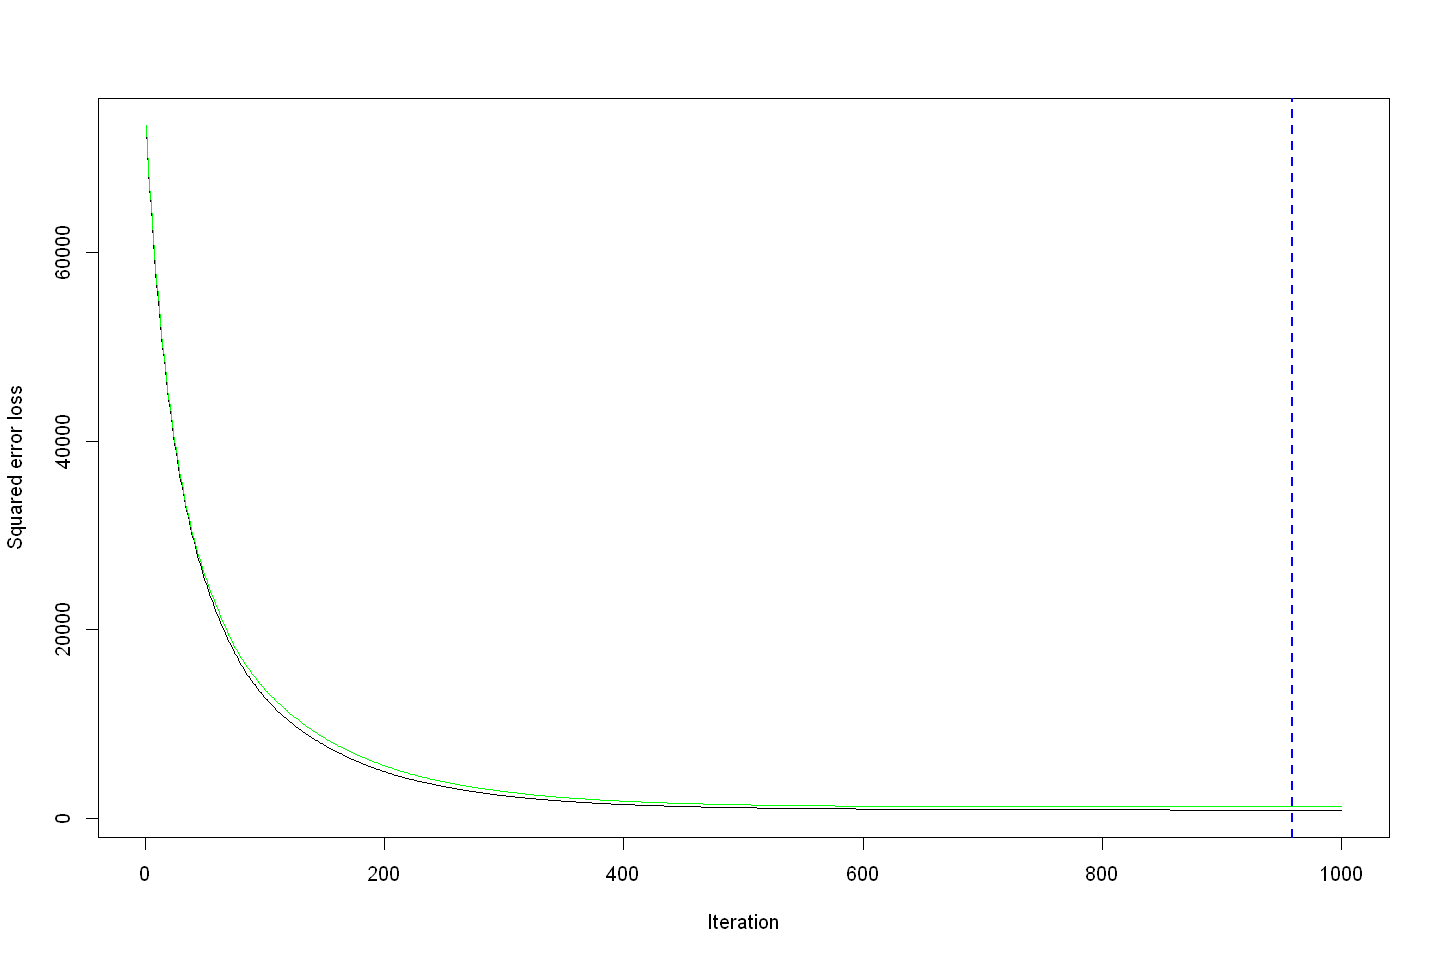

In [116]:
best.iter <- gbm.perf(boost.reg.cal, method="cv")

Stochastic Gradient Boosting 

779 samples
 13 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 622, 624, 623, 624, 623 
Resampling results across tuning parameters:

  shrinkage  interaction.depth  n.minobsinnode  n.trees  RMSE      Rsquared 
  0.01       1                  10               400     99.00823  0.9144422
  0.01       1                  10               800     58.84562  0.9675572
  0.01       1                  10              1000     48.97181  0.9753027
  0.01       1                  20               400     99.38495  0.9123045
  0.01       1                  20               800     59.87551  0.9658570
  0.01       1                  20              1000     50.22181  0.9736888
  0.01       3                  10               400     50.64958  0.9789792
  0.01       3                  10               800     22.67208  0.9942749
  0.01       3                  10              1000     19.25329  0.9956051
  0.01       3      

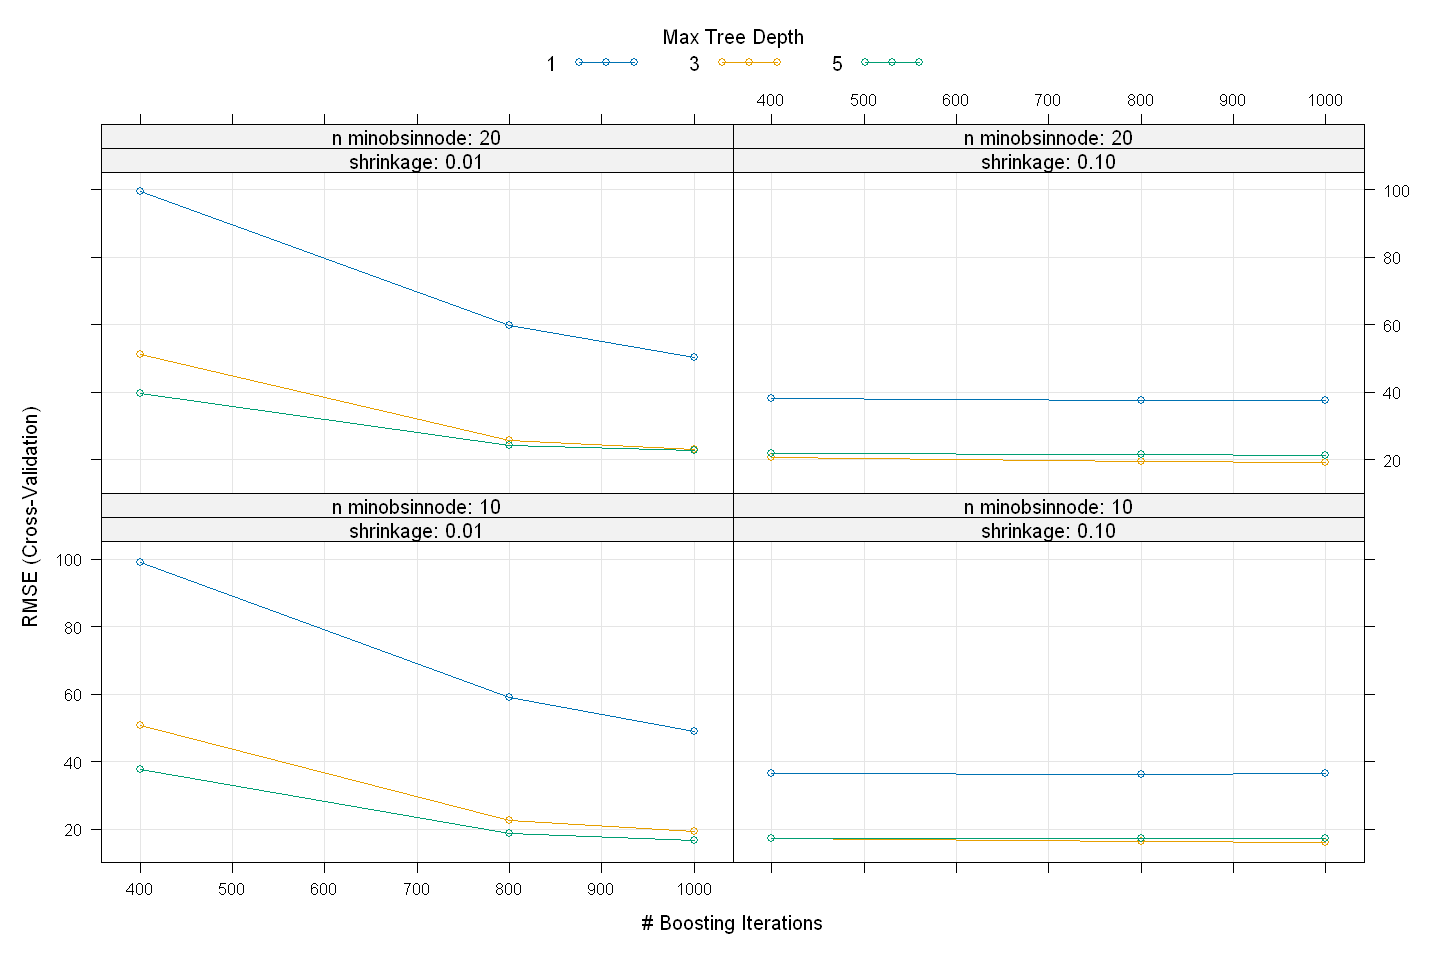

In [117]:
library(caret)
library(gbm)
library(dplyr)

# Définir la grille d'hyperparamètres
grid <- expand.grid(
  n.trees = c(400, 800, 1000), # Nombre d'arbres
  interaction.depth = c(1, 3, 5), # Profondeur max des arbres
  shrinkage = c(0.01, 0.1), # learning rate
  n.minobsinnode = c(10, 20) # Nombre minimum d'observations dans les nœuds terminaux
)

# Contrôle de validation croisée
ctrl <- trainControl(method = "cv", number = 5)

# Grid Search via caret::train
set.seed(123)
boost.reg.cal <- train(
  Calories_Burned ~ .,
  data = gym_train,
  method = "gbm",
  trControl = ctrl,
  tuneGrid = grid,
  verbose = FALSE
)

# Résultats
print(boost.reg.cal)
plot(boost.reg.cal)


In [172]:
best_result <- semi_join(boost.reg.cal$results, boost.reg.cal$bestTune, 
                         by = c("n.trees", "interaction.depth", "shrinkage", "n.minobsinnode"))

print(best_result)


  shrinkage interaction.depth n.minobsinnode n.trees     RMSE  Rsquared
1       0.1                 3             10    1000 15.91761 0.9967128
       MAE    RMSESD   RsquaredSD     MAESD
1 12.06274 0.8880248 0.0005429309 0.9301424


In [173]:
# compute MSE and R2 on training and test sets
mse_train <- mean((gym_train$Calories_Burned - predict(boost.reg.cal, gym_train))^2)
mse_test <- mean((gym_test$Calories_Burned - predict(boost.reg.cal, gym_test))^2)
r2_train <- 1 - mse_train / var(gym_train$Calories_Burned)
r2_test <- 1 - mse_test / var(gym_test$Calories_Burned)
# cat("MSE on training set: ", mse_train, "\n")
cat("MSE on test set: ", mse_test, "\n")
# cat("R2 on training set: ", r2_train, "\n")
cat("R2 on test set: ", r2_test, "\n")

MSE on test set:  212.954 
R2 on test set:  0.9969054 


**Interprétation des resultats du Boosting (GBM)** :

**Performance Exceptionnelle** :  
- **R²_test = 0.997** et **MSE_test = 213** : Le modèle explique **99.7%** de la variance des calories brûlées, avec une erreur moyenne de **±14.6 kcal** (√MSE).  
- **Supériorité Claire** : Il surpasse largement la forêt aléatoire (`R²_test=0.978`, `MSE_test=1519`), grâce à sa capacité à **optimiser séquentiellement les erreurs résiduelles** et à capturer des **interactions complexes**.  

**Explication de cette performance** :  
1. **Hyperparamètres Optimaux** :  
   - **`shrinkage=0.1`** (taux d’apprentissage bas) $\rightarrow$ Apprentissage stable et précis.  
   - **`interaction.depth=3`** $\rightarrow$ Abres de profondeur 3, permettant de capturer des interactions complexes sans surajuster.
   - **`n.trees=1000`** $\rightarrow$ Suffisant pour converger sans surapprentissage (grâce au faible `shrinkage`).  
2. **CV Robustesse** :  
   - **RMSE CV = 15.9 ± 0.89** $\rightarrow$ Très faible variabilité entre les folds, signe d’un modèle généralisable.  

**Bilan** :
Ces résultats positionnent **le GBM comme le modèle de référence pour la prédiction de `Calories_Burned`**, surpassant toutes les approches testées précédemment.

Pour aller plus loin, nous allons maintenant :

- Analyser les résidus : Vérifier l’absence de biais systématique même à haute intensité.  
- Feature Importance : Visualiser l'évolution de la prédiction de `Calories_Burned` en fonction des variables les plus explicatives de ce modèle.



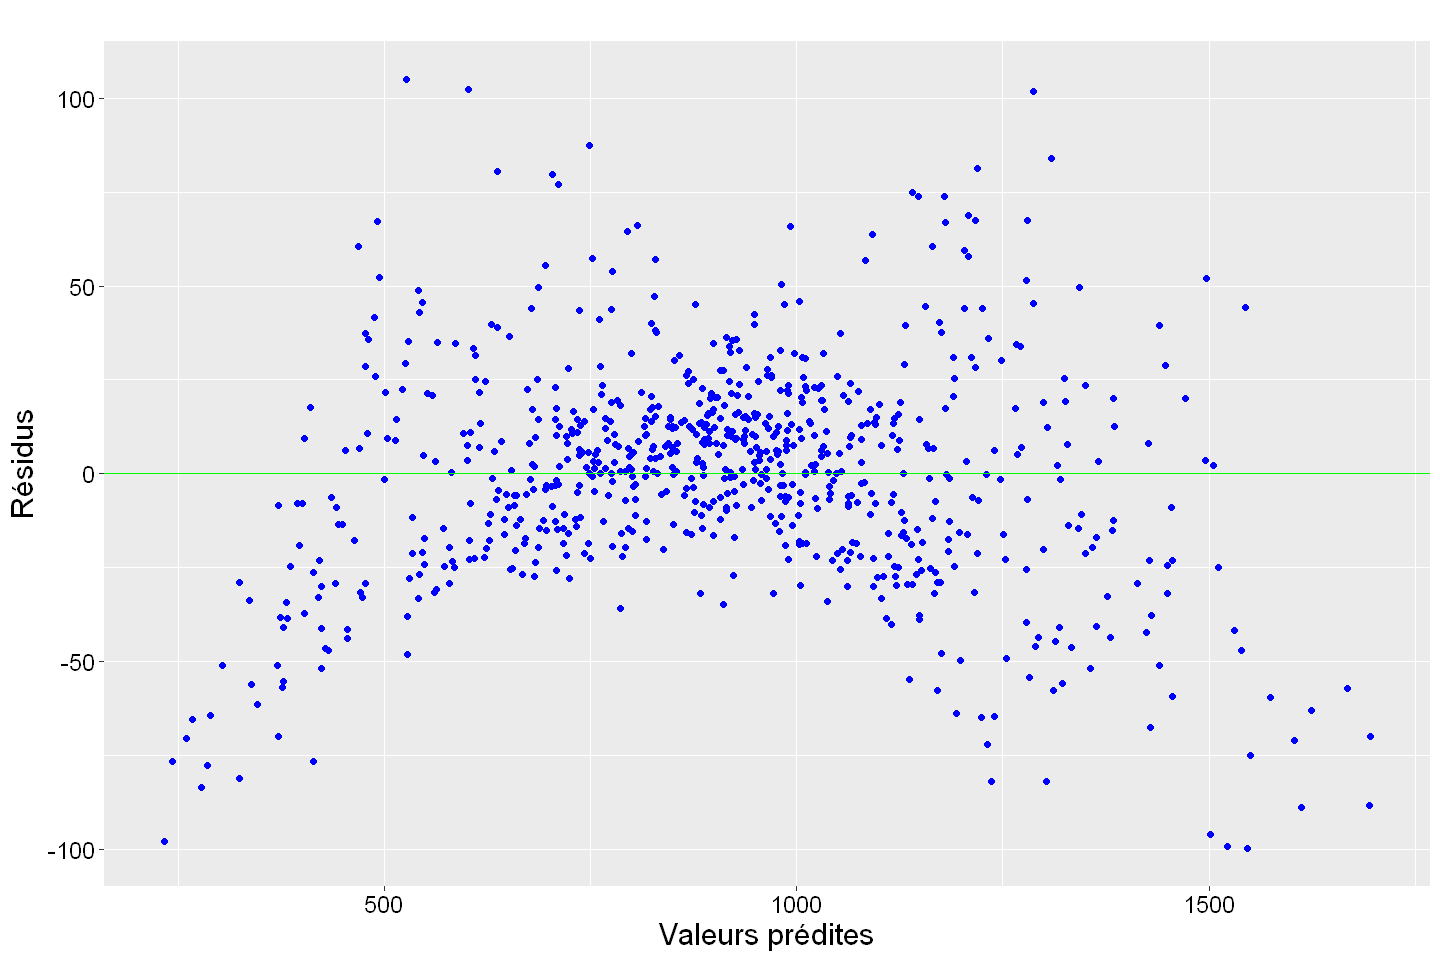

In [ ]:
fit.boostr.cal <- boost.reg.cal$fit
res.boostr.cal <- fit.boostr.cal - gym_train[,"Calories_Burned"]
gplot.res(fit.boostr.cal, res.boostr.cal, titre="")

**Interprétation des résidus** : Par rapport aux modèles précédents, les résidus du modèle de boosting sont beaucoup plus centrés autour de 0, avec une dispersion maximale de $\pm 100$ calories. On remarque tout de même que :

- la surestimation des valeurs prédites n'a lieu qu'entre 400 et 1500 calories mais pour les extrêmes (< 400 et > 1500 calories), le modèle sous-estime quasi-systemétiquement les calories brulées.


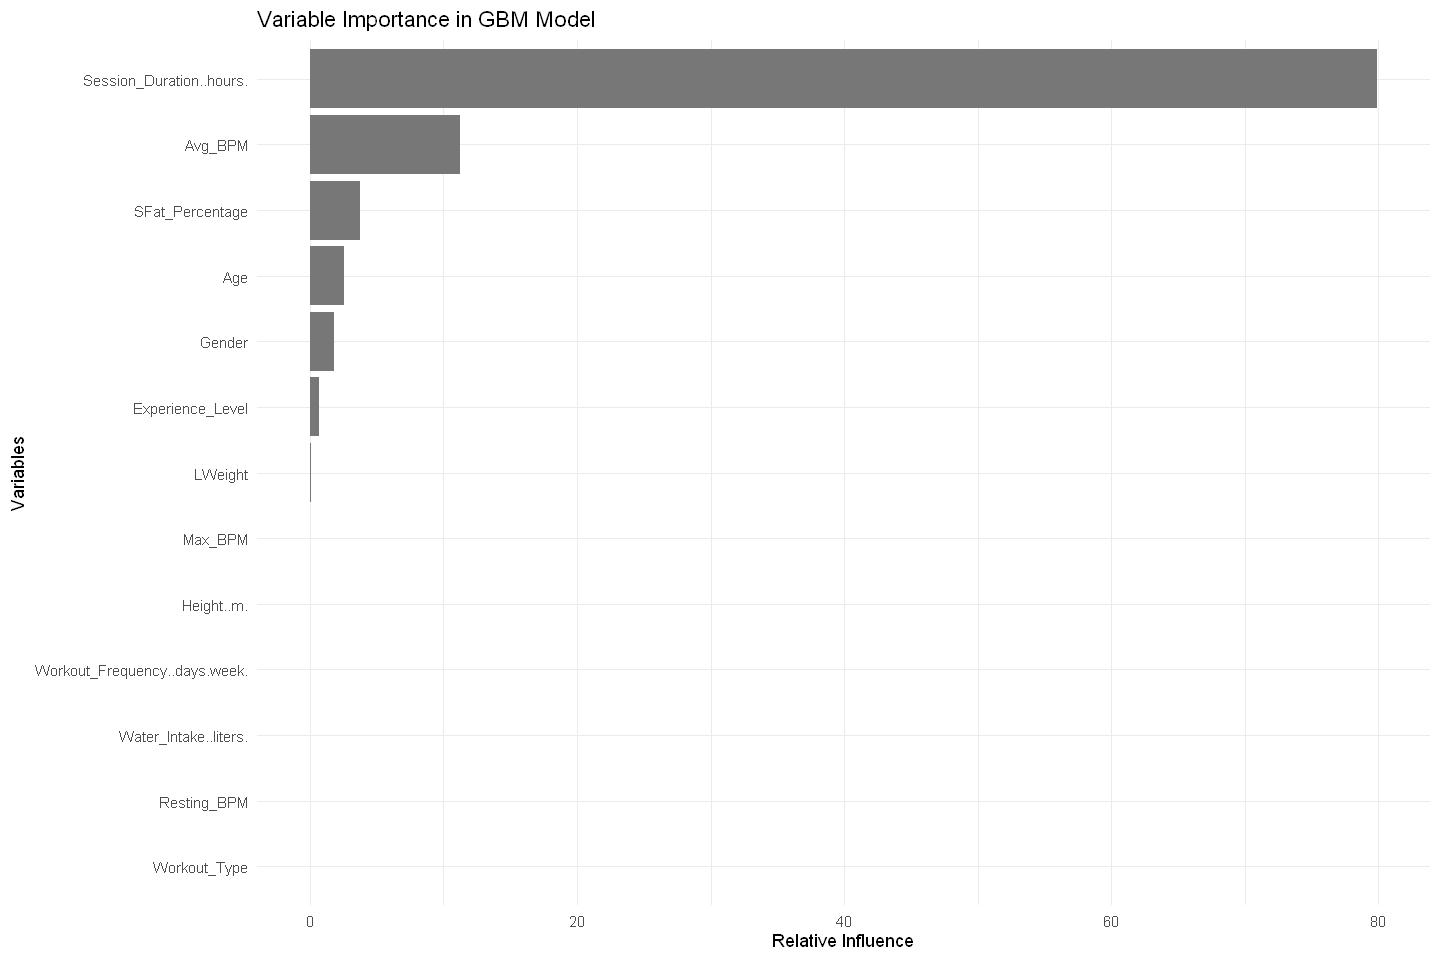

In [ ]:
# plot(gg_vimp(importance(boost.reg.cal)))
# Get variable importance from the GBM model
imp <- summary(boost.reg.cal, plotit = FALSE)

# Create a ggplot of variable importance
ggplot(imp, aes(x = reorder(var, rel.inf), y = rel.inf)) +
    geom_bar(stat = "identity", fill = "#777777") +
    coord_flip() +
    labs(x = "Variables", y = "Relative Influence", 
             title = "Variable Importance in GBM Model") +
    theme_minimal()

**Interprétation des variables importantes** :

Le GBM révèle une hiérarchie claire : `Session_Duration` (~80%) domine, suivie de `Avg_BPM` (~11%), confirmant les résultats de la forêt (`mtry=13`) et du Lasso. La faible importance de `SFat_Percentage` (~5%) et `Experience_Level` (~1%) suggère que leurs effets, bien que réels, sont majoritairement contextuels mais cela est à vérifier avec les partial dependence plots.

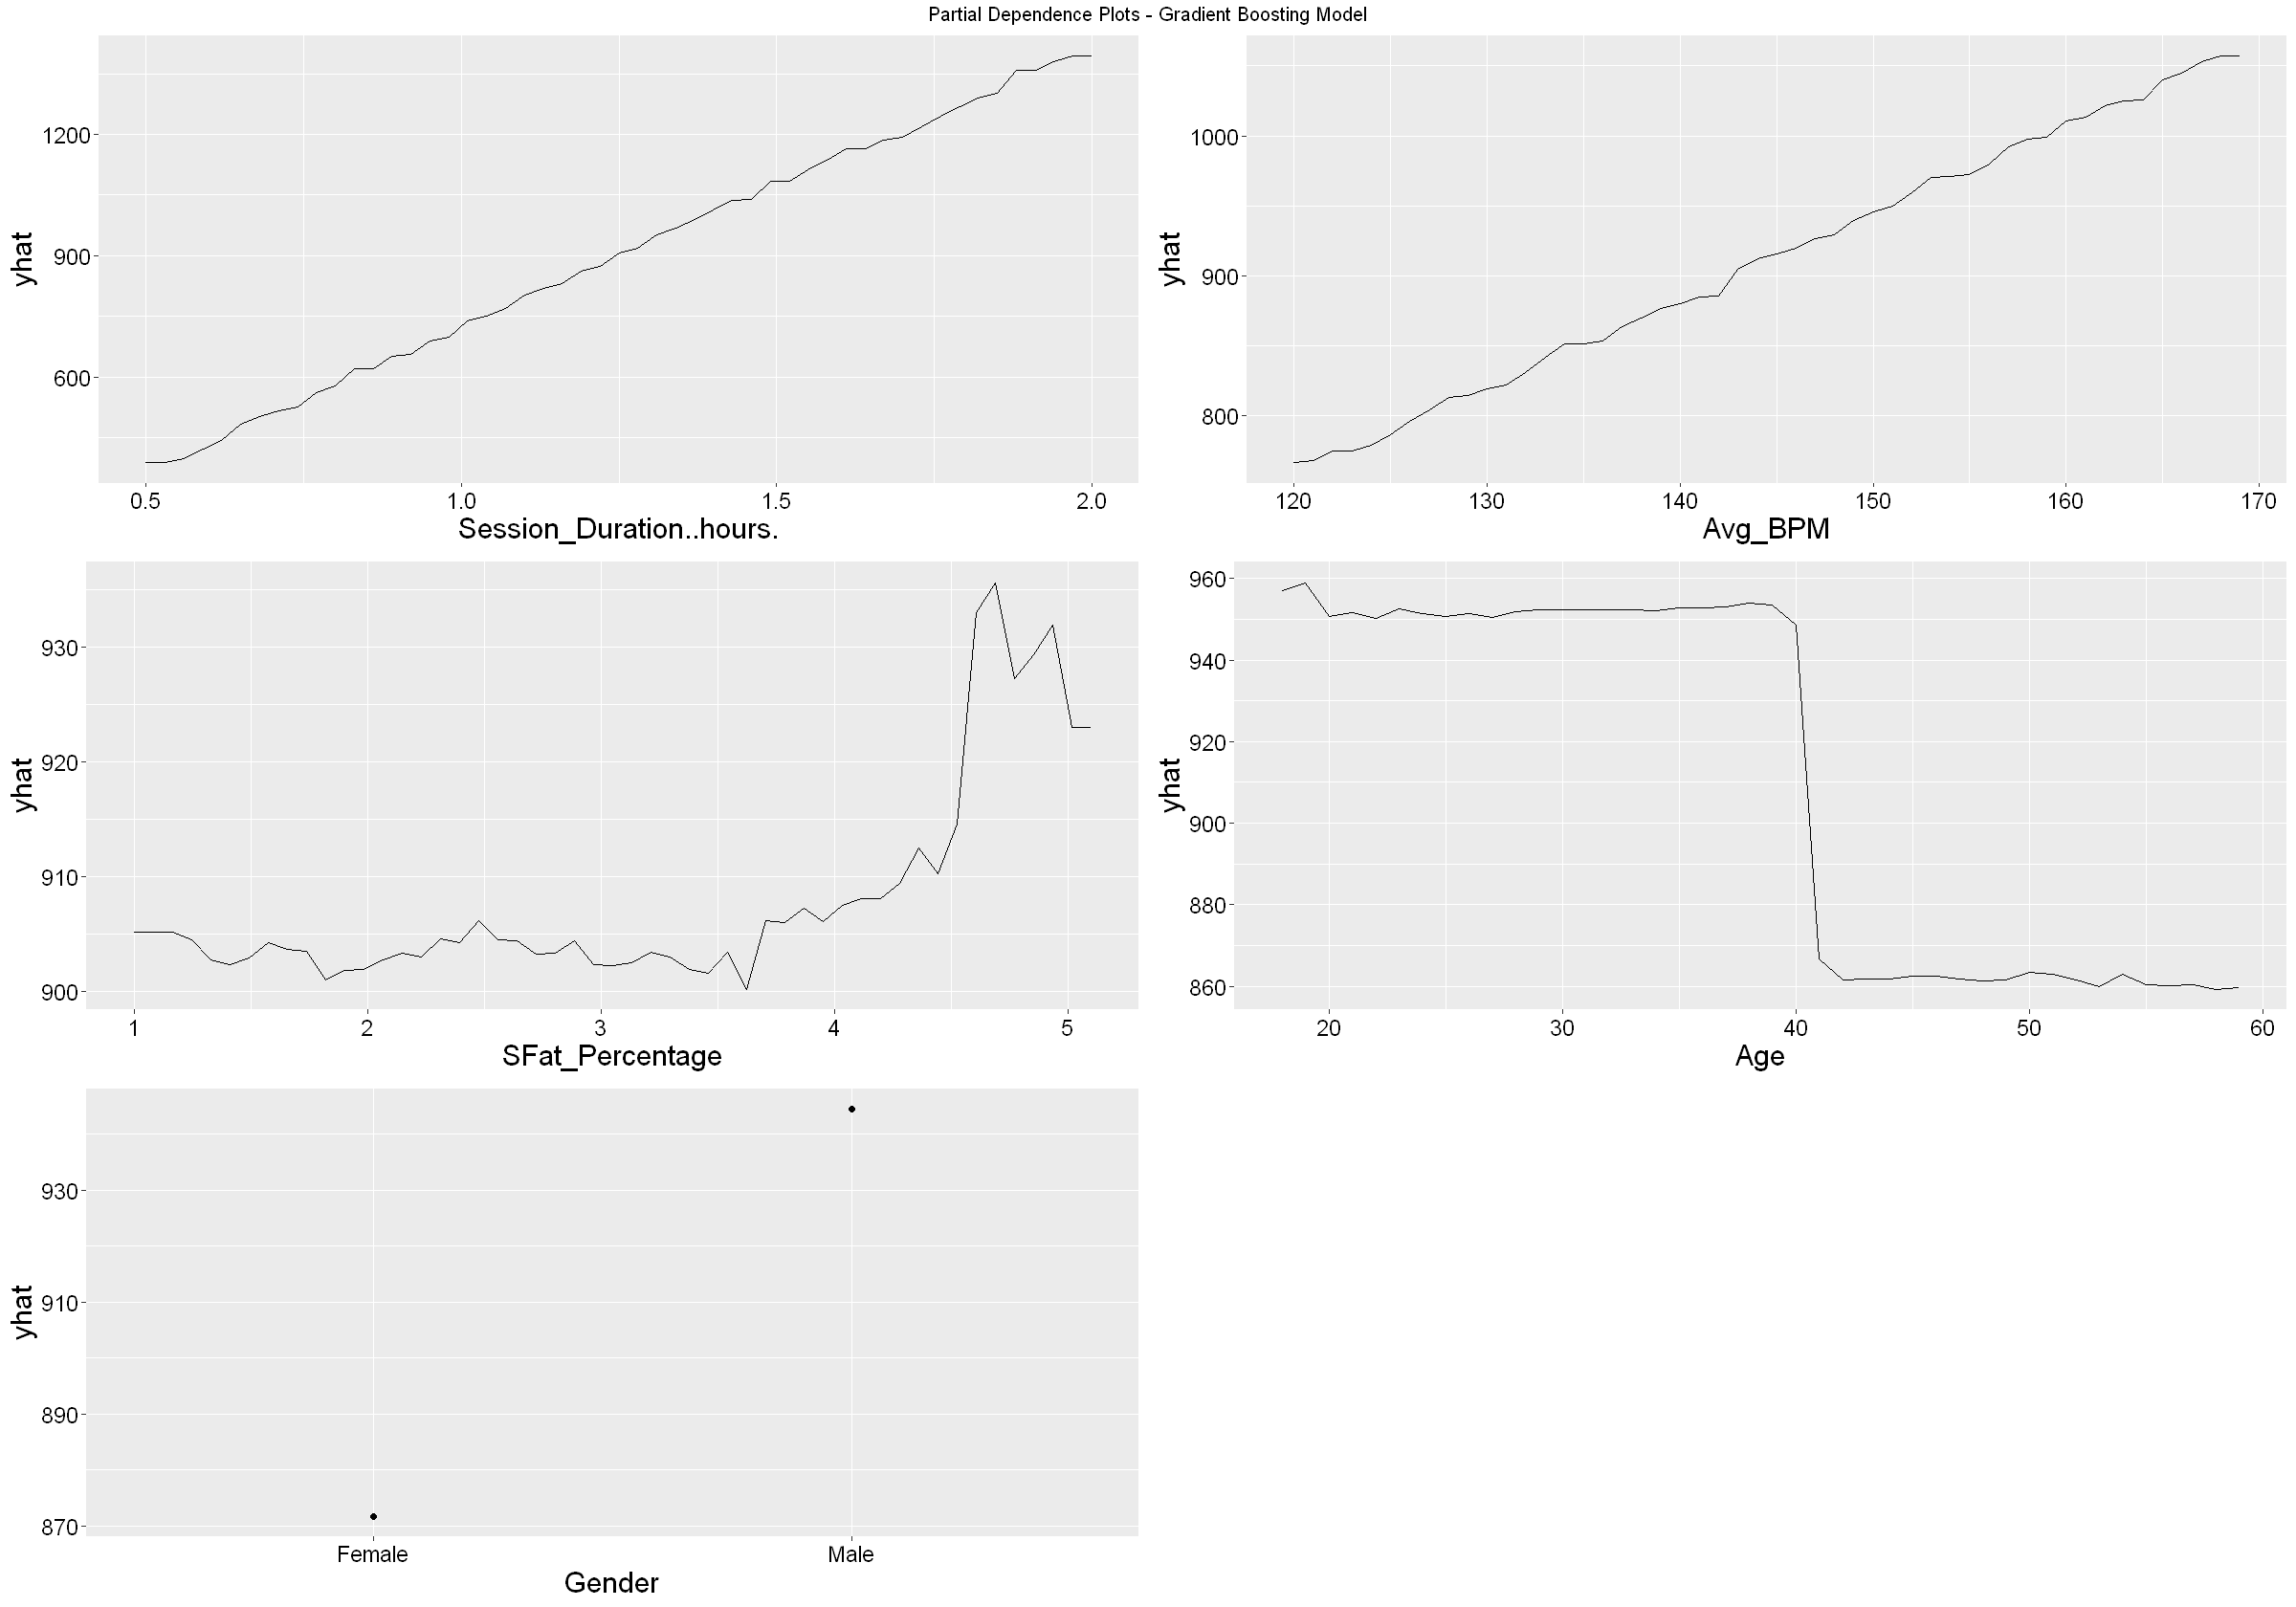

In [140]:
# PDP pour une variable (ex: Age)
pdp1 <- partial(boost.reg.cal, pred.var = "Session_Duration..hours.", rug = TRUE, train=gym_train, type="regression")
pdp2 <- partial(boost.reg.cal, pred.var = "Avg_BPM", rug = TRUE, train=gym_train, type="regression")
pdp3 <- partial(boost.reg.cal, pred.var = "SFat_Percentage", rug = TRUE, train=gym_train, type="regression")
pdp4 <- partial(boost.reg.cal, pred.var = "Age", rug = TRUE, train=gym_train, type="regression")
pdp5 <- partial(boost.reg.cal, pred.var = "Gender", rug = TRUE, train=gym_train, type="regression")

p1 <- autoplot(pdp1)
p2 <- autoplot(pdp2)
p3 <- autoplot(pdp3)
p4 <- autoplot(pdp4)
p5 <- autoplot(pdp5)

options(repr.plot.width=20, repr.plot.height=14)
main = "Partial Dependence Plots - Gradient Boosting Model"
grid.arrange(p1, p2, p3, p4, p5, ncol = 2, top = main)
rm(p1, p2, p3, p4, p5)


**Interpetation des PDP**:

Les partial dependence plots issus du modèle de Gradient Boosting permettent de visualiser l’impact isolé des variables sur la prédiction des calories brûlées. Ils confirment les résultats de l’analyse de l’importance des variables : 

- la durée de la séance (`Session_Duration..hours.`) et l’intensité de l’effort (`Avg_BPM`) sont les principaux déterminants avec des effets linéaires croissants. La durée de la séance a une influence de sur la variable cible, avec **un delta de 1000 calories entre les séances les plus courtes et les plus longues**. L’intensité de l’effort a également un impact significatif, avec **un delta de 400 calories entre les séances à 120 bpm et celles à 170 bpm** en moyenne. Ces résultats sont cohérents avec les analyses précédentes.
- le pourcentage de masse grasse (`SFatPercentage`) et l'age (`Age`) des individus on des interactions non lineaires avec la dépense calorique. :
  - En se remémorant la transformation de `FatPercentage`, les personnes **à faible taux de masse grasse ont une depense calorique plus importante** que les personnes à fort taux de masse grasse, **à effort égal**. 
  - Quant à l'age, on observe deux groupes : **les jeunes adultes (18-40 ans)** dépensent **près de 100 calories de plus** que **les personnes âgées entre 40 et 60 ans**, **à effort égal**. Ce résultat suggère un effet physiologique lié au vieillissement, notamment la perte de masse musculaire (sarcopénie), bien connue pour réduire la dépense énergétique. Cette hypothèse est cohérente avec les données scientifiques, qui montrent qu’à effort égal, un corps plus musclé consomme davantage de calories. Le modèle semble donc capter ici une relation non linéaire complexe entre l’âge, la composition corporelle et la dépense énergétique, malgré l’absence explicite de variable de masse musculaire dans le jeu de données. Il serait tout de même interessant de vérifier si la proportion de ces deux groupes de personnes est équilibrée dans le jeu de données, car il pourrait y avoir un biais de sélection.
- le genre (`Gender`) présente un léger effet marginal : les hommes brûlent légèrement plus de calories que les femmes (~70 calories d'écart).  


In [ ]:
# Calculer les proportions dans le jeu d'entraînement
prop_train <- prop.table(table(ifelse(gym_train$Age > 40, ">40", "<=40"))) * 100

# Calculer les proportions dans le jeu de test
prop_test <- prop.table(table(ifelse(gym_test$Age > 40, ">40", "<=40"))) * 100

# Afficher les proportions
cat("Proportions dans le jeu d'entraînement:")
print(prop_train)

cat("\nProportions dans le jeu de test:")
print(prop_test)

Proportions dans le jeu d'entraînement:
   <=40     >40 
52.1181 47.8819 

Proportions dans le jeu de test:
    <=40      >40 
53.60825 46.39175 


La répartition des âges est équilibrée (~52/48 % training, ~54/46 test), écartant l’hypothèse d’un biais de sélection. L’effet de l’âge observé dans le PDP reflète donc une tendance réelle, captée spécifiquement par le modèle de boosting — et non mise en évidence par les autres approches.

## Réseaux de neurones